# Model training
> Examples of how to train machine learning model to perform the pointwise characterization of single-trajectories.

In this tutorial, we show how to train machine learning models to predict diffusion properties of interest, such as the diffusion coefficient $D$, the anomalous diffusion exponent $\alpha$ or the diffusion model that best describes the observation (as in the [AnDi Challenge](https://www.nature.com/articles/s41467-021-26320-w)).

The methods presented here make extensive use of our [STEP library](https://borjarequena.github.io/step/). Follow the steps thoroughly to replicate the results of [our paper](https://arxiv.org/abs/2302.00410).

In [ ]:
#| hide
from step.data import *
from step.utils import *
from step.models import *
from step.baselines import diffusion_coefficient_tamsd, ruptures_cp
from fastai.vision.all import * 

from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate, tzip, tmap as tqmap

# Dataset

We train our models using the [fastai library](https://docs.fast.ai/) to handle the training loop. To do so, we combine the essential blocks of any training loop:

- A model to train
- A data loader
- A loss function
- An optimization algorithm (we use the default Adam)

Into a [`Learner`](https://docs.fast.ai/learner.html#learner) object. We can tweak all sorts of parameters and add, for example, data agumentation transforms, such as the `LocalizationNoise` we have defined above.

::: {.callout-note}
For anyone starting with machine learning, we recommend checking the [fastai courses](fast.ai) and their [book](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527), which is also available in [open source](https://github.com/fastai/fastbook).
:::

We start by creating the data loaders that will take the data from above. Since we are working with Brownian motion trajectories, we set `bm=True` and forget about the target, as it is always the diffusion coefficient. Actually, rather than predicting the actual value of the diffusion coefficient, we will work with its logarithm, so we set `tfm_y=torch.log10`. This allows us to mantain a constant relative error across all the orders of magnitude. Finally, we set the device to be the `default_device`, which is the first GPU, in case there is one, or the CPU.

In [ ]:
import torch
import numpy as np
from fastcore.all import *
from fastai.vision.all import *
from andi_datasets.datasets_phenom import datasets_phenom

def get_dls(N,T,dict_all, data_path,bs,target=[0],valid_pct=0.2,shuffle=True, dvc=default_device()):
    """Returns the DataLoaders with requested data and preprocessing"""
    """target 0: alpha, 1: D, 2: state, 3: CP, 4: alpha and D, ...??"""
    # from raw
    # load raw trajs and labels from phenomenological datasets
    trajs, labels = datasets_phenom().create_dataset(N_model = N, # number of trajectories per model
                                                     T = T,
                                                     dics = dict_all,
                                                     load = True, path = data_path,
                                                    )  # T, N, d (3)
    #trajs    # T, N, d Numpy arrays
    #labels   # T, N, 3:[D, alpha, state]
    
    # preprocessing on memory
    # if preproc=='disp':
    #     disp = trajs[1:]-trajs[:-1]  # T-1, N, d
    #     labels = labels[1:]          # T-1, N, 3
    # if 0 in target: 
    #     disp = trajs[1:] - trajs[:-1]
    #     std  = disp.std(0, keepdims=True) # keepdim for torch
    #     # print(len(std), std[0], std.shape, disp.shape)
    #     # trajs = torch.cat((torch.zeros_like(std), (disp/std).cumsum(1)), dim=1)
    #     trajs = np.concatenate((np.zeros_like(std), (disp/std).cumsum(0)),axis=0)
    
    # if 1 in target: labels=labels[1:] # logXResAttn predictions refer to the displacements and have length T-1.
    # # TODO: problem when predicting both alpha and D if D has T-1

    # displacements
    trajs  = trajs[1:]-trajs[:-1]  # T-1, N, d
    labels = labels[1:]            # T-1, N, 3
    # preprocessing to polar coordinates
    trajs = cartesian_to_polar(trajs)
    # transpose time and samples dimension
    trajs = np.transpose(trajs,axes=(1,0,2))
    labels = np.transpose(labels,axes=(1,0,2))
    
    # input x, target y
    x = trajs;    y = labels[:,:,target]
    # ensure data type
    x = x.astype(np.float32);  y = y.astype(np.float32)
    # form dataset
    ds = L(zip(x, y))  # N
    # create splitting
    idx = torch.randperm(len(ds)) if shuffle else tensor(range(len(ds)))
    split_pct = valid_pct
    cut = int(len(ds)*split_pct)
    train_ds, val_ds = ds[idx[cut:]], ds[idx[:cut]]
    return DataLoaders.from_dsets(train_ds, val_ds, bs=bs, shuffle=shuffle, device=dvc)
    # ds = np.concatenate((labels,ds),axis=-1)

    # processing on the fly
    # tfm = ConditionalsTransform(n_labels=n_labels)
    # n_inp = 1
    # splits_idx = RandomSplitter(valid_pct=ds_args['valid_pct'], seed=ds_args['seed'])(np.arange(len(ds)))
    # tfl = TfmdLists(ds, tfm, splits=splits_idx,)  # iter
    # return tfl.dataloaders(ds_args['bs'], n_inp=n_inp, num_workers=2, pin_memory=True, drop_last=True)
    
    # from preprocessed

    # return

In [ ]:
f=np.load('/media/scratrch_data/nanoninjas/data/raw/medium_13/track_2/trajectories_c.npz')

In [ ]:
for k in L(f.keys())[:-2]:
    if not np.all(np.isfinite(f[k])):
        print(k)

In [ ]:
f['20'].shape

(1086, 20, 6)

In [ ]:
# from numba import njit
# from numba.np.extensions import cross2d
#@njit
def get_angle_njit(a, b, c):
    vector_1 = b - a
    vector_2 = c - b 
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    # patch Bug fix acos(1.000001)
    # as in The  models_phenom.confinement computation of the reflection 
    #  It can be solved by clipping like suggested here (but better use arctan2 variant):
     # https://stackoverflow.com/a/48235342 
    ang = np.arccos(np.clip(dot_product, -1, 1))
    #ang = np.rad2deg(ang) # format at convenience
    d = np.cross(vector_2,vector_1) # TODO is this necessary???
    # TODO cross2d from numba gives nan for very close or orthogonal vectors
    # https://github.com/numba/numba/blob/df07de114404225e64eea3c0622d3aee4a12e0c8/numba/np/arraymath.py#L4816
    # look at more stable, and faster implementations:
    # https://scicomp.stackexchange.com/questions/27689/numerically-stable-way-of-computing-angles-between-vectors
    # https://stackoverflow.com/questions/78118265/efficiently-calculate-angle-between-three-points-over-triplets-of-rows-in-a-nump
    # https://stackoverflow.com/questions/35176451/python-code-to-calculate-angle-between-three-point-using-their-3d-coordinates#35178910
    return ang if d < 0 else -ang

def dataset_angles_(trajs # N,T, d
                  ):
    # TODO vectorized version in time
    # vecorized in N dimension assuming all trajs have same length, faster??
    angles = [[get_angle_njit(a, b, c) for (a, b, c) in zip(traj[:-2], traj[1:-1], traj[2:]) ]
              for traj in trajs]
    if isinstance(trajs, list):            return angles
    elif isinstance(trajs, np.ndarray):    return np.array(angles)

def get_angle(from_vec, # T, d=2
              to_vec,   # T, d=2
              ):
    x1, y1 = from_vec[...,0], from_vec[...,1]
    x2, y2 = to_vec[...,0], to_vec[...,1]
    dot = x1*x2 + y1*y2      # Dot product between [x1, y1] and [x2, y2]
    det = x1*y2 - y1*x2      # Determinant (cross2d) # 2.53 micros, njit 256 ns
    return np.arctan2(det, dot)

# We want a relative description of the trajectory
# the modulus of the displacement Delta r, and the change of angle between successive displacements Delta theta 
def cartesian_to_relative_polar(trajs_cart):
    """
    Converts 2D trajectories in cartesian coordinates to 
    a relative representation of polar coordinates.
    
    Parameters:
    - cartesian_coordinates:
    A numpy array of shape (N, T, 2) where
    N is the number of trajectories,
    T is the number of time steps, and
    2 represents the x and y coordinates.
    
    Returns:
    - An array containing:
    the radius (rho) of each point, and
    the angle from previous direction (theta) of each point in radians.
    """
    # take displacements of the trajectory
    disps_cart = trajs_cart[:, 1:] - trajs_cart[:, :-1]
    # Allocate
    polar_coords = np.zeros_like(disps_cart)
    
    # Calculate the magnitude (rho) of each point
    polar_coords[...,0] = np.hypot(disps_cart[..., 0], disps_cart[..., 1])  #  dr
    
    # Calculate the angle (theta) between segments
    v1,v2 = trajs_cart[:,1:-1]-trajs_cart[:,:-2], trajs_cart[:,2:]-trajs_cart[:,1:-1]
    polar_coords[:,1:,1] = get_angle(v1,v2) # d theta
    
    return polar_coords

In [ ]:
# will be imported from steproids ---------------------------------------------
from fastai.vision.all import *
from torch.utils.data import Dataset
#| export
class STDataset(Dataset):
    """Single trajectory-centric data set in which every sample is a single trajectory.
       Made with performance in mind for in-memory (mmap otherwise) datasets with bucketing.
    """
    # load the file in memory and slice it for batches.
    # Defining batch_size_=B*T as a constant, we make batches for each index.
    # For instance, idx=0 corresponds to T=20 so take B trajs from array of lengths=20 such that B*T==batch_size_
    # idx=1 takes the next bucket from T=20 array
    # so we need to map idx to length-mini-batch pair:
    # from known number of arrays with length T and bs create an indexable of pairs(length, slice)
    # to load that contiguous part
    def __init__(self, path,
                 bs: int,
                 target: int,
                 drop_last: bool=False,
                 load_600: bool=False,
                ):
        self.target = target
        #path = path/'trajectories.npz'
        f = np.load(path[-4]+'_600.npz') if load_600 else np.load(path)
        # rest of the pipeline not implemented for 600, left for custom batch cutting of variable length
        self.trajs = f
        # number of trajectories per length
        num_trajs_len = f['num_trajs_len']  #if hasattr(f, 'num_trajs_len') else np.array([v.shape[0] for v in L(f.values())[:-2]])
        self.num_trajs_len = num_trajs_len  # debug    
        lengths = f['lengths']  # 20,21...599
        self.lengths = lengths
        size_trajs_len = num_trajs_len * lengths  # size = num_trajs*T
        
        # how many buckets of size bs are on each length
        num_buc = size_trajs_len/bs
        if drop_last:
            num_buc = np.floor (num_buc).astype(int)
        else:  # take also incomplete buckets, not empty ones
            num_buc = np.ceil  (num_buc).astype(int)
        num_buc_cum = np.cumsum(num_buc)
        self.num_buc_cum = num_buc_cum
        
        # bucket lengths: how many N trajs of length T are on each length
        bucs_len = (bs / lengths).astype(int)
        # or equally distributed bucs per length bucs_len = num_trajs_len/num_buc
        self.bucs_len = bucs_len # debug
        
        # create bucket slices
        self.bucs = L([slice(i*blen,min((i+1)*blen, trajs_L))
                     for blen,n_buc,trajs_L in zip(bucs_len,num_buc, num_trajs_len)
                     for i in range(n_buc)])
        self.size = len(self.bucs)

    def __len__(self):
        "Return the number of batches in the dataset"
        return self.size
        
    def idx2lenbuc(self, idx):
        # length from index for desired bs
        l = np.digitize(idx, self.num_buc_cum) 
    
        # compute here every time
        # num_buc_cum_0 = np.concatenate((self.num_buc_cum,[0]))
        # b_idx = idx-num_buc_cum_0[l-1]
        
        # buc = slice(b_idx*self.bucs_len[l],min((b_idx+1)*self.bucs_len[l],self.num_trajs_len[l]))
        # assert buc==self.bucs[idx], f'{idx=} {num_buc_cum_0[l-1]=} {b_idx=} {buc=} {self.bucs[idx]=}'
        
        # or take precomputed ---------v
        return self.lengths[l], self.bucs[idx]
    
    def __getitem__(self, idx):
        if idx<0: idx= self.size+idx-1
        l, buc = self.idx2lenbuc(idx)
        # finally, slice and split into inputs and targets: xb, yb
        # trajs = {'20':ndarray(N', T=20,F)}, F=x,y,alpha,D,state
        x = self.trajs[str(l)][buc,:, :2]  # x, y
        x = cartesian_to_relative_polar(x) # dr, dtheta
        if self.target==0:
            #y = self.trajs[str(l)][buc,:, 2:3] # alpha
            y = self.trajs[str(l)][buc,1:, 2:3] # alpha [1:]
        if self.target==1:
            y = self.trajs[str(l)][buc,1:, 3:4]
            # for old STEP comment the following
            x[...,0] = np.log10(x[...,0]) # log10 dr
            y = np.log10(np.maximum(y,1e-10)) # log10 D [1:]
        if self.target==2: #                     state
            y = self.trajs[str(l)][buc,:,4:5].astype(int)
        if self.target==3: #                                                               cps
            y = self.trajs[str(l)][buc,:,5:6].astype(int)
            y[:,-1] = 0 # erase last (in time dimension) cp indicating sequence length
        return x,y #batch

class STPDataset(Dataset):
    """Single trajectory predictions-centric data set in which every sample is a prediction of a single trajectory.
       Made with performance in mind for in-memory (mmap otherwise) datasets with bucketing.
    """
    # load the file in memory and slice it for batches.
    # Defining batch_size_=B*T as a constant, we make batches for each index.
    # For instance, idx=0 corresponds to T=20 so take B trajs from array of lengths=20 such that B*T==batch_size_
    # idx=1 takes the next bucket from T=20 array
    # so we need to map idx to length-mini-batch pair:
    # from known number of arrays with length T and bs create an indexable of pairs(length, slice)
    # to load that contiguous part
    def __init__(self, path_x, path_y,
                 bs: int,
                 drop_last: bool=False,
                 load_600: bool=False,
                ):
        #path = path/'trajectories.npz'
        self.x = np.load(path_x)
        f = np.load(path_y[-4]+'_600.npz') if load_600 else np.load(path_y)
        # rest of the pipeline not implemented for 600, left for custom batch cutting of variable length
        self.trajs = f
        # number of trajectories per length
        num_trajs_len = f['num_trajs_len'] # if hasattr(f, 'num_trajs_len') else np.array([v.shape[0] for v in L(f.values())[:-2]])
        self.num_trajs_len = num_trajs_len  # debug    
        lengths = f['lengths']  # 20,21...599
        self.lengths = lengths
        size_trajs_len = num_trajs_len * lengths  # size = num_trajs*T
        
        # how many buckets of size bs are on each length
        num_buc = size_trajs_len/bs
        if drop_last:
            num_buc = np.floor (num_buc).astype(int)
        else:  # take also incomplete buckets, not empty ones
            num_buc = np.ceil  (num_buc).astype(int)
        num_buc_cum = np.cumsum(num_buc)
        self.num_buc_cum = num_buc_cum
        
        # bucket lengths: how many N trajs of length T are on each length
        bucs_len = (bs / lengths).astype(int)
        # or equally distributed bucs per length bucs_len = num_trajs_len/num_buc
        self.bucs_len = bucs_len # debug
        
        # create bucket slices
        self.bucs = L([slice(i*blen,min((i+1)*blen, trajs_L))
                     for blen,n_buc,trajs_L in zip(bucs_len,num_buc, num_trajs_len)
                     for i in range(n_buc)])
        self.size = len(self.bucs)

    def __len__(self):
        "Return the number of batches in the dataset"
        return self.size
        
    def idx2lenbuc(self, idx):
        # length from index for desired bs
        l = np.digitize(idx, self.num_buc_cum) 
    
        # compute here every time
        # num_buc_cum_0 = np.concatenate((self.num_buc_cum,[0]))
        # b_idx = idx-num_buc_cum_0[l-1]
        
        # buc = slice(b_idx*self.bucs_len[l],min((b_idx+1)*self.bucs_len[l],self.num_trajs_len[l]))
        # assert buc==self.bucs[idx], f'{idx=} {num_buc_cum_0[l-1]=} {b_idx=} {buc=} {self.bucs[idx]=}'
        
        # or take precomputed ---------v
        return self.lengths[l], self.bucs[idx]
    
    def __getitem__(self, idx):
        if idx<0: idx= self.size+idx-1
        l, buc = self.idx2lenbuc(idx)
        # finally, slice and split into inputs and targets: xb, yb
        # trajs = {'20':ndarray(N', T=20,F)}, F=x,y,alpha,D,state
        #                                 x,y                         state
        #batch = self.trajs[str(l)][buc,:, :2], self.trajs[str(l)][buc,:,4:5].astype(int)
        #                                                               cps
        y = self.trajs[str(l)][buc,:,5:6].astype(int)
        y[:,-1] = 0 # erase last (in time dimension) cp indicating sequence length
        #             preds: alpha,log10D; target: cps
        batch = self.x[str(l)][buc,:, :2], y
        return batch
#| export
#https://github.com/fastai/fastai/blob/master/fastai/data/load.py#L85
class DataLoaderIndexed(DataLoader):
    def __init__(self, idxs, *args, **kwargs):
        super().__init__(*args, **kwargs)
        store_attr()
    def get_idxs(self):
        idxs = self.idxs #Inf.count if self.indexed else Inf.nones
        #if self.n is not None: idxs = list(itertools.islice(idxs, self.n))
        if self.shuffle: idxs = self.shuffle_fn(idxs)
        return idxs
#| export
def _get_dls_from_ds(ds, split_pct=0.2, shuffle=True):
    "Returns `DataLoaders` built from `ds`."
    idx = torch.randperm(len(ds)).tolist() if shuffle else list(range(len(ds)))
    cut = int(len(ds)*split_pct)
    train_dl = DataLoaderIndexed(L(idx[cut:]),ds, shuffle=shuffle) # pin_memory=True
    # train_dl.idxs = L(idx[cut:])
    # TODO DataLoaderIndexed without ?? No, It will fail the purpose when fastai creates a new dl for get_preds
    valid_dl = DataLoaderIndexed(L(idx[:cut]),ds, shuffle=False)
    return DataLoaders(train_dl, valid_dl,)
#------------------------------------------------------------------------------
def get_dls_array(data_path, bs_: int, target: int, split_pct, drop_last: bool=False):
    return _get_dls_from_ds(STDataset(data_path, bs_, target, drop_last=drop_last), split_pct,)
def get_dls_array_preds(preds_path, data_path, bs_, drop_last: bool=False):
    return _get_dls_from_ds(STPDataset(preds_path, data_path, bs_, drop_last=drop_last))

In [ ]:
class STBigDataset(Dataset):
    """Single trajectory-centric data set in which every sample is a single trajectory.
       Made with performance in mind for in-memory (mmap otherwise) datasets with bucketing.
    """
    # load the file in memory and slice it for batches.
    # Defining batch_size_=B*T as a constant, we make batches for each index.
    # For instance, idx=0 corresponds to T=20 so take B trajs from array of lengths=20 such that B*T==batch_size_
    # idx=1 takes the next bucket from T=20 array
    # so we need to map idx to length-mini-batch pair:
    # from known number of arrays with length T and bs create an indexable of pairs(length, slice)
    # to load that contiguous part
    def __init__(self, path, # data_path/f'big'/f"track_{2}"/f'trajectories_c_L{k}'
                 bs: int,
                 target: int,
                 drop_last: bool=False,
                 memmap_mode= None,
                ):
        self.target = target
        lengths = np.arange(20,600)
        self.lengths = lengths
        trajs = {str(l):np.load(path/f'trajectories_c_L{l}.npy', mmap_mode=memmap_mode) for l in tqdm(lengths)}
        print('Loaded')
        # in-memory transform
        if target==1:
            for k,v in tqdm(trajs.items()):
                trajs[k][:,:,[3,6]] = np.log10(np.maximum(v[:,:,[3,6]],1e-10)) # log10 (D,dr)
            print('Log10-transformed D and dr')
        self.trajs = trajs
        # number of trajectories per length
        num_trajs_len = np.array([v.shape[0] for v in trajs.values()])
        self.num_trajs_len = num_trajs_len  # debug
        size_trajs_len = num_trajs_len * lengths  # size = num_trajs*T
        
        # how many buckets of size bs are on each length
        num_buc = size_trajs_len/bs
        if drop_last:
            num_buc = np.floor (num_buc).astype(int)
        else:  # take also incomplete buckets, not empty ones
            num_buc = np.ceil  (num_buc).astype(int)
        num_buc_cum = np.cumsum(num_buc)
        self.num_buc_cum = num_buc_cum
        
        # bucket lengths: how many N trajs of length T are on each length
        bucs_len = (bs / lengths).astype(int)
        # or equally distributed bucs per length bucs_len = num_trajs_len/num_buc
        self.bucs_len = bucs_len # debug
        
        # create bucket slices
        self.bucs = L([slice(i*blen,min((i+1)*blen, trajs_L))
                       for blen,n_buc,trajs_L in zip(bucs_len,num_buc, num_trajs_len)
                       for i in range(n_buc)])
        self.size = len(self.bucs)

    def __len__(self):
        "Return the number of batches in the dataset"
        return self.size
        
    def idx2lenbuc(self, idx):
        # length from index for desired bs
        l = np.digitize(idx, self.num_buc_cum)
        return self.lengths[l], self.bucs[idx]
    
    def __getitem__(self, idx):
        if idx<0: idx= self.size+idx-1
        l, buc = self.idx2lenbuc(idx)
        # finally, slice and split into inputs and targets: xb, yb
        # trajs = {'20':ndarray(N', T=20,F)}, F=x,y,alpha,D,state, dr,dtheta
        # x = self.trajs[str(l)][buc,:, :2]  # x, y
        # x = cartesian_to_relative_polar(x) # dr, dtheta
        x = self.trajs[str(l)][buc,1:, -2:]  #if target ==0  else  self.trajs[str(l)][buc,:, :2] # dr, dtheta or x,y
        if self.target==0:
            #y = self.trajs[str(l)][buc,:, 2:3] # alpha
            y = self.trajs[str(l)][buc,1:, 2:3] # alpha [1:]
        if self.target==1:
            y = self.trajs[str(l)][buc,1:, 3:4]
            # for old STEP comment the following
            # x[...,0] = np.log10(np.maximum(x[...,0],1e-10)) # log10 dr
            # #x[...,0] = np.sign(x)*np.log10(np.maximum(np.abs(x),1e-10))
            # y = np.log10(np.maximum(y,1e-10)) # log10 D [1:]
        if self.target==2: #                     state
            y = self.trajs[str(l)][buc,:,4:5].astype(int)
        if self.target==3: #                                                               cps
            y = self.trajs[str(l)][buc,:,5:6].astype(int)
            y[:,-1] = 0 # erase last (in time dimension) cp indicating sequence length
        return x,y #batch

def get_big_dls_array(data_path, bs_: int, target: int,split_pct, drop_last: bool=False):
    return _get_dls_from_ds(STBigDataset(data_path, bs_, target, drop_last=drop_last), split_pct)

In [ ]:
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/baby/track_2/trajectories.npz")
# data_path = Path("/media/scratrch_data/nanoninjas/data/raw/medium_0/track_2/trajectories.npz")
bs_ = 200*20
dls = get_dls_array(data_path, bs_)
dim = 2

In [ ]:
preds_path = Path("/media/scratrch_data/nanoninjas/data/raw/baby/track_2/step_baby_pred.npz")
# preds_path = Path("/media/scratrch_data/nanoninjas/data/raw/medium_0/track_2/step_medium_0_pred.npz")
bs_ = 200*20
dls = get_dls_array_preds(preds_path, data_path, bs_)
dim = 2

In [ ]:
dls.one_batch()

(tensor([[[ 0.4394,  1.4211],
          [ 0.4770,  1.4211],
          [ 0.4869,  1.4092],
          ...,
          [ 0.3739,  1.3901],
          [ 0.4028,  1.4005],
          [ 0.4397,  1.3520]],
 
         [[ 0.8610,  0.0824],
          [ 0.8536,  0.0824],
          [ 0.8419,  0.0822],
          ...,
          [ 0.8261,  0.0720],
          [ 0.7942,  0.0617],
          [ 0.8721,  0.0072]],
 
         [[ 1.6824, -0.2789],
          [ 1.7108, -0.2789],
          [ 1.7112, -0.2237],
          ...,
          [ 1.6620, -0.2525],
          [ 1.6506, -0.4582],
          [ 1.6593, -0.6519]],
 
         ...,
 
         [[ 0.6447,  1.3039],
          [ 0.7070,  1.3039],
          [ 0.7734,  1.2684],
          ...,
          [ 0.6054,  1.2806],
          [ 0.5868,  1.2814],
          [ 0.6131,  1.2257]],
 
         [[ 0.8111,  1.4567],
          [ 0.8298,  1.4567],
          [ 0.8320,  1.4391],
          ...,
          [ 0.8786,  1.5301],
          [ 0.8438,  1.5107],
          [ 0.8446,  1.4337

In [ ]:
dim=2

N = 600
box_L = 200
T = 400
# state = diffusive, trapped
alphas = [1.0,       0.05]
Ds =     [10**-0.45, 10**-1.5]
M  = np.array([[0.98, 0.02],
          [0.01, 0.99]])
dict_model_1 = dict(model ='multi_state', L = box_L,
                    alphas = alphas, Ds = Ds, M = M)

data_path = "../../data/raw/"
dict_all = [dict_model_1]

In [ ]:
default_device()

device(type='cuda', index=0)

In [ ]:
bs=128
dls = get_dls(N=600, T=400, dict_all=dict_all,
              data_path=data_path, bs=bs,valid_pct=0.2,shuffle=True)

In [ ]:
dls.device

device(type='cuda', index=0)

In [ ]:
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([3, 399, 2]), torch.Size([3, 399, 1]))

In [ ]:
with default_device():
    model = XResAttn(dim, n_class=1, stem_szs=(32,), conv_blocks=[1, 1, 1],
                 block_szs=[128, 256, 512], dropout=0., pos_enc=False, n_encoder_layers=4,
                 dim_ff=512, nhead_enc=8, linear_layers=[],)

In [ ]:
model.act, model.activation

(<function fastai.imports.noop(x=None, *args, **kwargs)>, Softmax(dim=-1))

In [ ]:
nn.CrossEntropyLoss?

Init signature:
nn.CrossEntropyLoss(
    weight: Optional[torch.Tensor] = None,
    size_average=None,
    ignore_index: int = -100,
    reduce=None,
    reduction: str = 'mean',
    label_smoothing: float = 0.0,
) -> None
Docstring:     
This criterion computes the cross entropy loss between input logits
and target.

It is useful when training a classification problem with `C` classes.
If provided, the optional argument :attr:`weight` should be a 1D `Tensor`
assigning weight to each of the classes.
This is particularly useful when you have an unbalanced training set.

The `input` is expected to contain the unnormalized logits for each class (which do `not` need
to be positive or sum to 1, in general).
`input` has to be a Tensor of size :math:`(C)` for unbatched input,
:math:`(minibatch, C)` or :math:`(minibatch, C, d_1, d_2, ..., d_K)` with :math:`K \geq 1` for the
`K`-dimensional case. The last being useful for higher dimension inputs, such
as computing cross entropy loss per-pixel f

In [ ]:
XResAttn??

Init signature:
XResAttn(
    dim,
    n_class=5,
    conv_blocks=[1, 1],
    block=<class 'fastai.layers.ResBlock'>,
    block_szs=[64, 128],
    nhead_enc=1,
    n_encoder_layers=6,
    dim_ff=2048,
    dropout=0.1,
    pos_enc=True,
    linear_layers=[128],
    activation='relu',
    norm=True,
    yrange=(0, 2.05),
    *,
    expansion=1,
    p=0.0,
    c_in=1,
    n_out=1000,
    stem_szs=(32, 32, 64),
    widen=1.0,
    ndim=1,
    ks=3,
    stride=2,
    sa=False,
    stem_stride=False,
    act_cls=<class 'torch.nn.modules.activation.ReLU'>,
    groups=1,
    reduction=None,
    nh1=None,
    nh2=None,
    dw=False,
    g2=1,
    sym=False,
    norm_type=<NormType.Batch: 1>,
    pool=<function AvgPool at 0x76f6fb2ab4c0>,
    pool_first=True,
    padding=None,
    bias=None,
    bn_1st=True,
    transpose=False,
    init='auto',
    xtra=None,
    bias_std=0.01,
    dilation: Union[int, Tuple[int, int]] = 1,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
)
Sour

In [ ]:
model

XResAttn(
  (norm): Normalization()
  (convs): XResBlocks(
    (0): ConvLayer(
      (0): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ResBlock(
        (convpath): Sequential(
          (0): ConvLayer(
            (0): Conv1d(32, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
            (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
          (1): ConvLayer(
            (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
            (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (idpath): Sequential(
          (0): ConvLayer(
            (0): Conv1d(32, 128, kernel_size=(1,), stride=(1,), bias=False)
            (1): BatchNorm1d(12

In [ ]:
BCEWithLogitsLossFlat.__call__??

Signature:
BCEWithLogitsLossFlat.__call__(
    self,
    inp: 'Tensor | MutableSequence',
    targ: 'Tensor | MutableSequence',
    **kwargs,
) -> 'TensorBase'
Docstring: Call self as a function.
Source:   
    def __call__(self, 
        inp:Tensor|MutableSequence, # Predictions from a `Learner`
        targ:Tensor|MutableSequence, # Actual y label
        **kwargs
    ) -> TensorBase: # `loss_cls` calculated on `inp` and `targ`
        inp,targ  = map(self._contiguous, (inp,targ))
        if self.floatify and targ.dtype!=torch.float16: targ = targ.float()
        if targ.dtype in [torch.int8, torch.int16, torch.int32]: targ = targ.long()
        if self.flatten: inp = inp.view(-1,inp.shape[-1]) if self.is_2d else inp.view(-1)
        return self.func.__call__(inp, targ.view(-1) if self.flatten else targ, **kwargs)
File:      ~/miniforge3/envs/step/lib/python3.11/site-packages/fastai/losses.py
Type:      function

In [ ]:
with default_device():
    state_label_weights=torch.tensor([1/1.7,1/1.5,1.,1/1.7])
    loss_fn_state = BCEWithLogitsLossFlat()#CrossEntropyLossFlat()#weight=state_label_weights)

In [ ]:
uniform_guess = torch.tensor([[[0.25,0.25,0.25,0.25]]*x.shape[1]]*x.shape[0], device=default_device())
uniform_guess.shape, y.shape

(torch.Size([30, 66, 4]), torch.Size([30, 66]))

In [ ]:
uniform_guess_loss = loss_fn_state(uniform_guess.cuda(), y.squeeze().cuda()); uniform_guess_loss

TensorBase(1.3863, device='cuda:0')

In [ ]:
mode_guess = torch.tensor([[[-100.]]*x.shape[1]]*x.shape[0], device=default_device())
mode_guess.shape, y.shape

(torch.Size([3, 399, 1]), torch.Size([3, 399, 1]))

In [ ]:
mode_guess_loss = loss_fn_state(mode_guess.cuda(), y.squeeze().cuda()); mode_guess_loss

TensorBase(0.4177, device='cuda:0')

In [ ]:
torch.unique(y)

tensor([1, 2, 3])

In [ ]:
cbs = ShowGraphCallback()

In [ ]:
MODEL_PATH

Path('/media/scratrch_data/gfernandez/STEProids/models')

In [ ]:
learn = Learner(dls, model, loss_func=loss_fn_state,#L1LossFlat(),
                model_dir=MODEL_PATH, cbs=cbs)
learn.to(default_device());

In [ ]:
learn.dls.one_batch()[0].shape

torch.Size([27, 146, 2])

A rather handy functionality of the learner is the `lr_find` method. This function trains the model for a few mini-batches changing the learning rate. Then, we can visualize the loss and determine the regions where the model is learning, where the learning rate is too low and where it diverges.

In [ ]:
learn.summary()

XResAttn (Input shape: 9 x 414 x 2)
Layer (type)         Output Shape         Param #    Trainable 
                     9 x 414 x 2         
Normalization                                                  
____________________________________________________________________________
                     9 x 32 x 414        
Conv1d                                    192        True      
BatchNorm1d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     9 x 128 x 414       
Conv1d                                    12288      True      
BatchNorm1d                               256        True      
ReLU                                                           
Conv1d                                    49152      True      
BatchNorm1d                               256        True      
Conv1d                                    40

SuggestedLRs(valley=0.0063095735386013985)

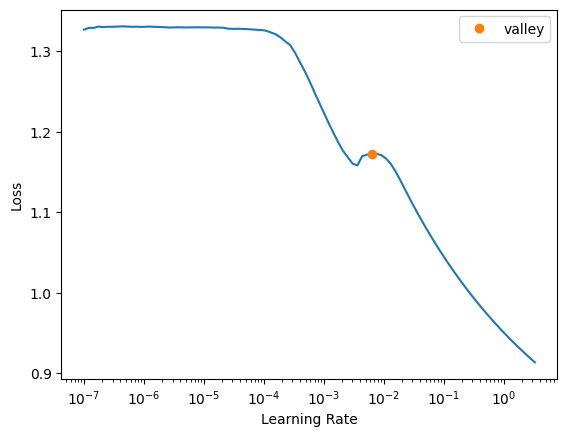

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.689434,0.682516,10:15
1,0.689555,0.682331,09:11


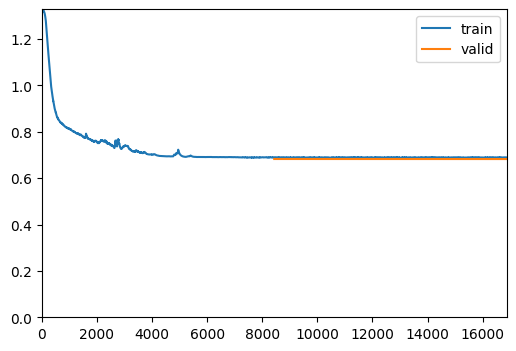

In [ ]:
learn.fit_one_cycle(2, lr_max=1e-4)#2e-4)

epoch,train_loss,valid_loss,time
0,0.883350,0.769530,00:11
1,0.777344,1.072872,00:11
2,0.688908,0.895392,00:11
3,0.687085,0.735030,00:11
4,0.716736,0.662901,00:11
5,0.720430,6.071524,00:11
6,0.658123,2.006618,00:11
7,0.746481,39.850430,00:11
8,0.979173,6.249897,00:11
9,0.679116,43.414227,00:11


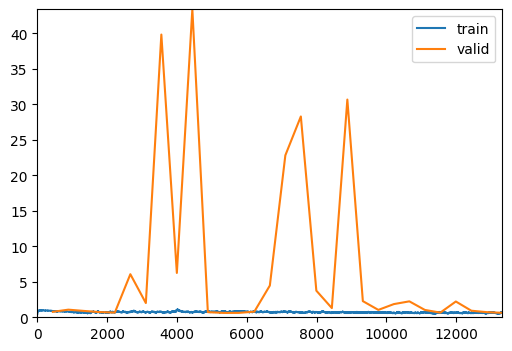

In [ ]:
learn.fit_one_cycle(30, lr_max=5e-4)

epoch,train_loss,valid_loss,time
0,0.640035,0.661828,00:11
1,0.620535,0.629896,00:11
2,0.626649,1.585592,00:11
3,0.775076,0.793954,00:11
4,0.634861,0.666927,00:11


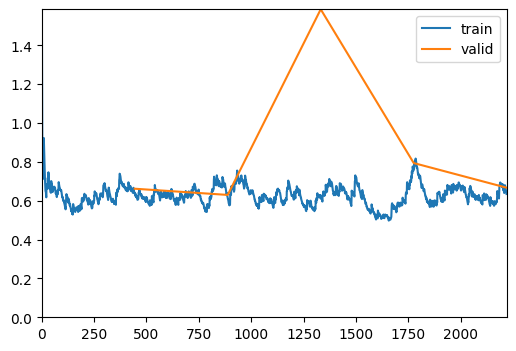

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-5)

epoch,train_loss,valid_loss,time
0,0.565554,0.663586,00:11
1,0.574868,0.583175,00:11
2,0.609810,0.656519,00:11
3,0.682369,0.639848,00:11
4,0.626197,0.689882,00:11


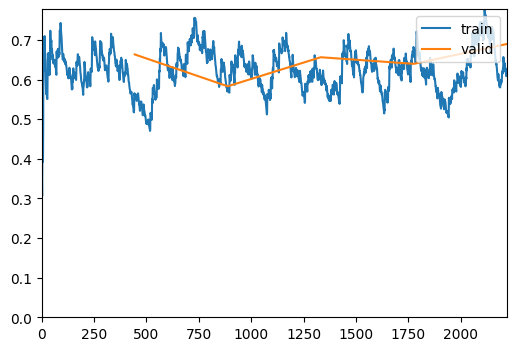

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-6)

epoch,train_loss,valid_loss,time
0,0.602596,0.671797,00:11
1,0.564362,0.669888,00:11
2,0.575326,0.666921,00:11
3,0.661129,0.745486,00:11
4,0.695493,0.663936,00:11


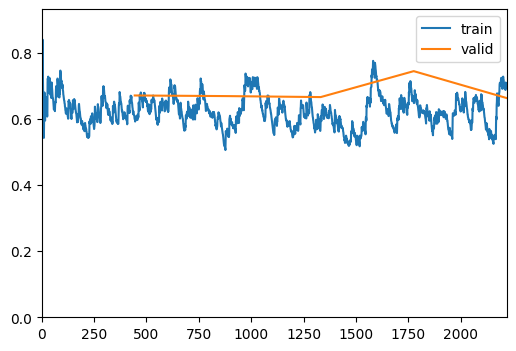

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-6)

In [ ]:
nn.CrossEntropyLoss()

In [ ]:
xv,yv = dls[1].one_batch()

In [ ]:
yv

tensor([0, 1, 2, 3])

In [ ]:
with torch.no_grad():
    x,y = learn.dls.one_batch()
    pred = learn.model(x.cuda()).cpu()
    y = y.cpu()
    y, pred = y.squeeze(), pred.squeeze()

In [ ]:
y.shape, pred.shape

(torch.Size([30, 94]), torch.Size([30, 94, 4]))

In [ ]:
#pred

In [ ]:
#torch.argmax(pred,dim=-1)

  0%|          | 0/18 [00:00<?, ?it/s]

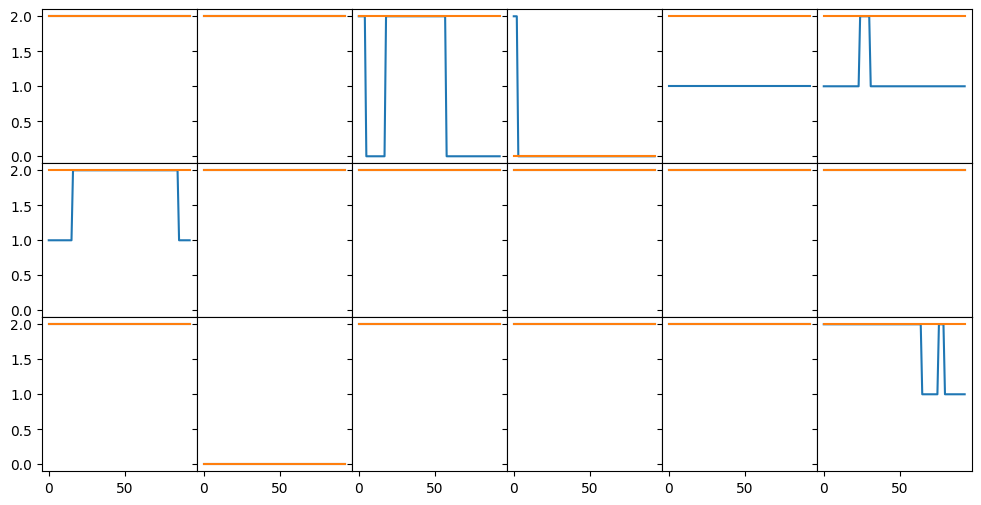

In [ ]:
n=3
fig, axs = plt.subplots(n,2*n, figsize=(12,6), 
                        sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0, hspace=0))
for i, ax in tenumerate(axs.flatten()):
    ax.plot(y[i]);ax.plot(torch.argmax(pred[i],dim=-1));

# Alpha

In [ ]:
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/baby/track_2/trajectories.npz")
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/medium_0/track_2/trajectories_c.npz")
bs_ = 400*20
dls = get_dls_array(data_path, bs_, target=0, split_pct=0.2, drop_last=False)
dim = 2

In [ ]:
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/big/track_2/")
bs_ = 400*20
dls = get_big_dls_array(data_path, bs_, target=0, split_pct=0.05, drop_last=False)
dim = 2

In [ ]:
b=dls.one_batch()
b[0].shape, b[1].shape

(torch.Size([14, 557, 2]), torch.Size([14, 556, 1]))

In [ ]:
lengths_ = [b[0].shape[1] for b in tqdm(dls.train)]

  0%|          | 0/208624 [00:00<?, ?it/s]

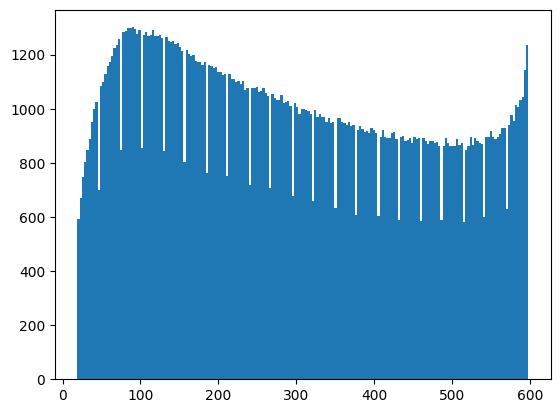

In [ ]:
plt.hist(lengths_,200); # all trajs except length 600, have a mean of 20 batches with small length having more

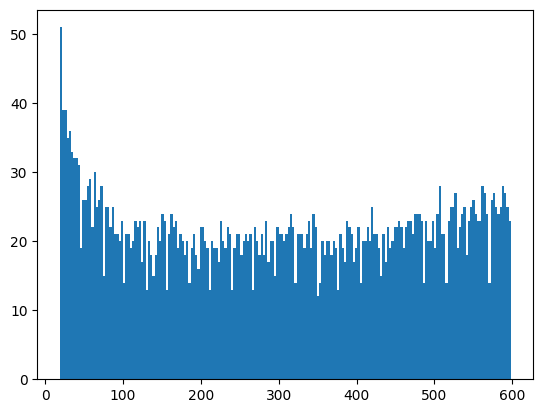

In [ ]:
plt.hist(lengths_,200); # all trajs except length 600, have a mean of 20 batches with small length having more

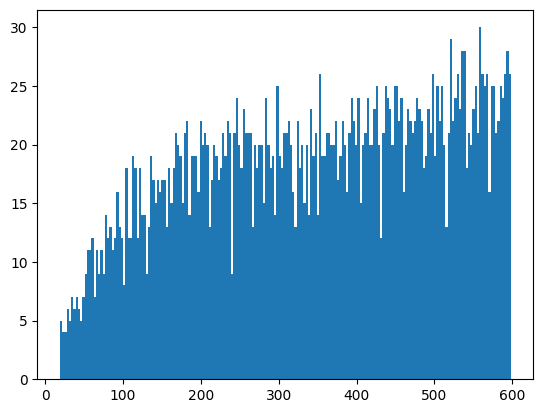

In [ ]:
plt.hist(lengths_,200);  # curated with 4/1=homo/hetero leads to small number of batches of small length

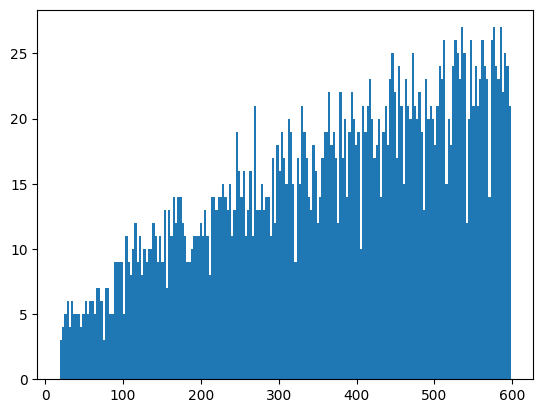

In [ ]:
plt.hist(lengths_,200); # 2/1

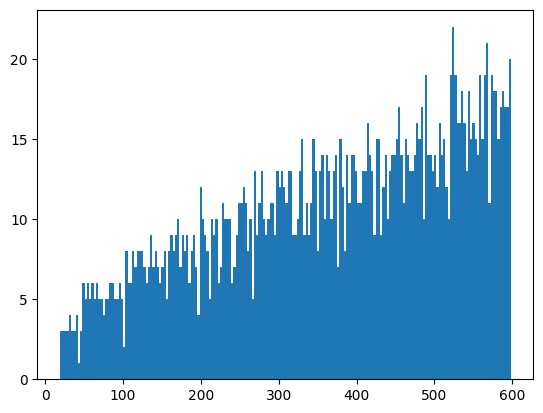

In [ ]:
plt.hist(lengths_,200); # 1/1

## debug nans coming from numba cross2d and numpy.arccos

In [ ]:
dls2.train.dataset.idx2lenbuc(41)

(22, slice(1815, 2178, None))

In [ ]:
dls2  = get_dls_array(data_path, bs_, drop_last=True)

In [ ]:
dls2.train.dataset.trajs['21'][1583:1584,].shape

(1, 21, 6)

In [ ]:
t= dls2.train.dataset.trajs['21'][1583:1584,:,:2]

In [ ]:
t= dls2.train.dataset.trajs['22'][1980:1981,:,:2]

In [ ]:
dataset_angles_(t)

/tmp/ipykernel_1453314/2546815735.py:10: RuntimeWarning: invalid value encountered in arccos
  ang = np.arccos(dot_product)


array([[-0.03740911, -2.017314  ,         nan, -2.5269313 ,  1.9451869 ,
        -1.8672643 , -1.4992919 , -1.8822114 , -1.3245355 , -0.14573666,
         0.19755074,  2.17281   ,  0.7593699 ,  1.0959234 ,  0.6185493 ,
        -1.0879076 ,  0.11843336,  0.09940586, -2.3601587 ,  0.97787803]],
      dtype=float32)

In [ ]:
np.argwhere(np.isnan(dataset_angles_(t)))

/tmp/ipykernel_1453314/2546815735.py:10: RuntimeWarning: invalid value encountered in arccos
  ang = np.arccos(dot_product)


array([[0, 2]])

In [ ]:
i=2
get_angle_njit(t[0,i], t[0,i+1], t[0,i+2])

/tmp/ipykernel_1453314/2546815735.py:10: RuntimeWarning: invalid value encountered in arccos
  ang = np.arccos(dot_product)


nan

In [ ]:
a,b,c = t[0,i], t[0,i+1], t[0,i+2]
vector_1 = b - a
vector_2 = c - b 
vector_1, vector_2

(array([4.0286484, 2.8837738], dtype=float32),
 array([-2.234024 , -1.5993881], dtype=float32))

In [ ]:
unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
unit_vector_1, unit_vector_2

(array([0.8131443 , 0.58206224], dtype=float32),
 array([-0.81310356, -0.58211917], dtype=float32))

In [ ]:
dot_product = np.dot(unit_vector_1, unit_vector_2)
dot_product

-1.0000001

In [ ]:
ang = np.arccos(dot_product)
ang

/tmp/ipykernel_1453314/2479214848.py:1: RuntimeWarning: invalid value encountered in arccos
  ang = np.arccos(dot_product)


nan

In [ ]:
np.arccos(-1.00001)

/tmp/ipykernel_1453314/3413818370.py:1: RuntimeWarning: invalid value encountered in arccos
  np.arccos(-1.00001)


nan

In [ ]:
np.cross(vector_2,vector_1)

array(-0.1665678, dtype=float32)

In [ ]:
cross2d??

Signature: cross2d(a, b)
Docstring: <no docstring>
Source:   
def cross2d(a, b):
    pass
File:      ~/miniforge3/envs/step/lib/python3.11/site-packages/numba/np/arraymath.py
Type:      function

In [ ]:
njit(cross2d)(np.array([32,22]),np.array([3,44]))

In [ ]:
#ang = np.rad2deg(ang) # format at convenience
d = cross2d(vector_2,vector_1) # TODO is this necessary???
d

In [ ]:
print(d)

None


In [ ]:
ang if d < 0 else -ang

TypeError: '<' not supported between instances of 'NoneType' and 'int'

In [ ]:
get_angle_njit??

Signature:       get_angle_njit(a, b, c)
Call signature:  get_angle_njit(*args, **kwargs)
Type:            CPUDispatcher
String form:     CPUDispatcher(<function get_angle_njit>)
File:            /tmp/ipykernel_1453314/3261442868.py
Source:         
@njit
def get_angle_njit(a, b, c):
    vector_1 = b - a
    vector_2 = c - b 
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    ang = np.arccos(dot_product)
    #ang = np.rad2deg(ang) # format at convenience
    d = cross2d(vector_2,vector_1) # TODO is this necessary???
    return ang if d < 0 else -ang
Class docstring:
Implementation of user-facing dispatcher objects (i.e. created using
the @jit decorator).
This is an abstract base class. Subclasses should define the targetdescr
class attribute.
Init docstring: 
Parameters
----------
py_func: function object to be compiled
locals: dict, optional
    Mapping of local vari

In [ ]:
[get_angle_njit(a, b, c) for (a, b, c) in zip(traj[:-2], traj[1:-1], traj[2:])]

[nan,
 2.434420585632324,
 -0.6847765445709229,
 -2.152733564376831,
 1.339131474494934,
 2.197685718536377,
 0.9959239363670349,
 2.46974515914917,
 2.33907413482666,
 -2.4691011905670166,
 2.1083059310913086,
 2.711773157119751,
 0.848850667476654,
 1.4958440065383911,
 0.7440991401672363,
 2.4102137088775635,
 -2.866572141647339,
 2.9434399604797363,
 0.1797415167093277]

In [ ]:
dataset_angles_??

Signature: dataset_angles_(trajs)
Docstring: <no docstring>
Source:   
def dataset_angles_(trajs # N,T, d
                  ):
    # TODO vectorized version in time
    # vecorized in N dimension assuming all trajs have same length, faster??
    angles = [[get_angle_njit(a, b, c) for (a, b, c) in zip(traj[:-2], traj[1:-1], traj[2:]) ]
              for traj in trajs]
    if isinstance(trajs, list):            return angles
    elif isinstance(trajs, np.ndarray):    return np.array(angles)
File:      /tmp/ipykernel_1453314/3261442868.py
Type:      function

In [ ]:
cartesian_to_relative_polar(dls2.train.dataset.trajs['21'][1583:1584,:,:2])

array([[[18.925808 ,  0.       ],
        [12.852549 ,  3.1409948],
        [17.198442 ,  2.4344206],
        [ 6.459044 , -0.6847765],
        [10.30931  , -2.1527338],
        [19.045084 ,  1.3391315],
        [ 3.8295884,  2.197686 ],
        [29.016808 ,  0.9959239],
        [18.085033 ,  2.4697452],
        [19.438541 ,  2.3390744],
        [10.099355 , -2.4691014],
        [ 4.611539 ,  2.1083062],
        [14.872146 ,  2.7117732],
        [13.561217 ,  0.8488507],
        [17.17844  ,  1.495844 ],
        [ 9.353259 ,  0.7440992],
        [24.25486  ,  2.410214 ],
        [ 9.466473 , -2.8665724],
        [ 8.825579 ,  2.94344  ],
        [ 5.6510696,  0.1797415]]], dtype=float32)

In [ ]:
np.argwhere(np.isnan(dls.train.dataset[22][0]))

array([[63,  1,  1]])

In [ ]:
dls.train.dataset.idx2lenbuc(22)

(21, slice(1520, 1900, None))

In [ ]:
dls.train.dataset[22][0][63]

array([[18.925808  ,  0.        ],
       [12.852549  ,         nan],
       [17.198442  ,  2.4344206 ],
       [ 6.459044  , -0.68477654],
       [10.30931   , -2.1527336 ],
       [19.045084  ,  1.3391315 ],
       [ 3.8295884 ,  2.1976857 ],
       [29.016808  ,  0.99592394],
       [18.085033  ,  2.4697452 ],
       [19.438541  ,  2.3390741 ],
       [10.099355  , -2.4691012 ],
       [ 4.611539  ,  2.108306  ],
       [14.872146  ,  2.7117732 ],
       [13.561217  ,  0.84885067],
       [17.17844   ,  1.495844  ],
       [ 9.353259  ,  0.74409914],
       [24.25486   ,  2.4102137 ],
       [ 9.466473  , -2.8665721 ],
       [ 8.825579  ,  2.94344   ],
       [ 5.6510696 ,  0.17974152]], dtype=float32)

In [ ]:
dls.train.dataset[41][0][63]

/tmp/ipykernel_1453314/2546815735.py:10: RuntimeWarning: invalid value encountered in arccos
  ang = np.arccos(dot_product)


array([[21.448025  ,  0.        ],
       [10.738765  ,  1.127755  ],
       [10.76219   ,  0.71857667],
       [11.079268  ,  1.4854449 ],
       [ 1.991027  , -2.2585368 ],
       [10.655546  ,  0.7151972 ],
       [19.84925   , -3.131403  ],
       [13.537509  , -1.6271356 ],
       [ 8.343447  , -1.0477222 ],
       [23.893263  , -2.5477107 ],
       [ 5.5561028 ,  1.932238  ],
       [14.037982  , -1.4888297 ],
       [ 5.5259757 ,  2.5501647 ],
       [10.72182   , -3.0018609 ],
       [ 3.1304405 , -0.9260876 ],
       [12.43889   , -2.3441677 ],
       [ 7.6013417 , -0.6719363 ],
       [15.14694   , -1.0285708 ],
       [ 9.749988  , -1.6823204 ],
       [ 2.8825948 , -2.3362064 ],
       [17.46245   ,  1.3696271 ]], dtype=float32)

In [ ]:
# check there are no nans in the dataset
for i,t in tenumerate(dls.train.dataset):
    if np.any(np.isnan(t[0])): print(i)

  0%|          | 0/4833 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print(i)

3664


## train alpha

In [ ]:
b = dls.one_batch()

In [ ]:
b[0].shape, b[0].device, b[1].shape

(torch.Size([72, 109, 2]), device(type='cpu'), torch.Size([72, 109, 1]))

In [ ]:
b[0][:,:,0].min(), b[0][:,:,1].min(), b[0][:,:,0].max(), b[0][:,:,1].max()

(tensor(0.0083), tensor(-3.1404), tensor(35.7603), tensor(3.1410))

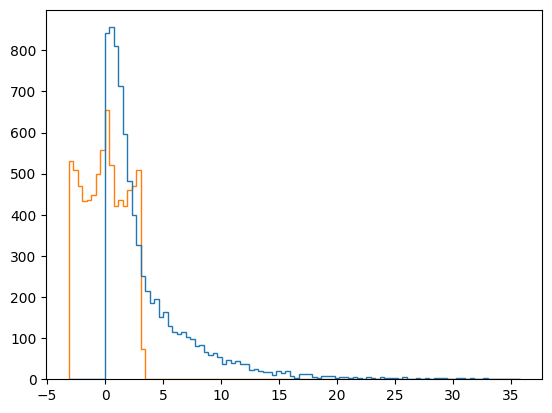

In [ ]:
plt.hist(b[0].reshape(-1,2).numpy(), 100, histtype='step');

In [ ]:
with default_device():
    model = XResAttn(dim, n_class=1, stem_szs=(32,), conv_blocks=[1, 1, 1],
                 block_szs=[128, 256, 512], dropout=0., pos_enc=False, n_encoder_layers=4,
                 dim_ff=512, nhead_enc=8, norm=False, linear_layers=[], yrange=(-0.1,2.1))

In [ ]:
model.norm??

Signature:      model.norm(dim=-1)
Call signature: model.norm(*args, **kwargs)
Type:           Normalization
String form:    Normalization()
File:           ~/Downloads/step/step/models.py
Source:        
class Normalization(Module):
    "Z-Normalization over the designated dimension."
    def __init__(self, dim=-1): self.dim = dim
    def forward(self, x): 
        return (x - x.mean(self.dim).unsqueeze(self.dim))/x.std(self.dim).unsqueeze(self.dim)
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.

In [ ]:
ConvLayer??

Init signature:
ConvLayer(
    ni,
    nf,
    ks=3,
    stride=1,
    padding=None,
    bias=None,
    ndim=2,
    norm_type=<NormType.Batch: 1>,
    bn_1st=True,
    act_cls=<class 'torch.nn.modules.activation.ReLU'>,
    transpose=False,
    init='auto',
    xtra=None,
    bias_std=0.01,
    *,
    dilation: Union[int, Tuple[int, int]] = 1,
    groups: int = 1,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
)
Source:        
class ConvLayer(nn.Sequential):
    "Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and `norm_type` layers."
    @delegates(nn.Conv2d)
    def __init__(self, ni, nf, ks=3, stride=1, padding=None, bias=None, ndim=2, norm_type=NormType.Batch, bn_1st=True,
                 act_cls=defaults.activation, transpose=False, init='auto', xtra=None, bias_std=0.01, **kwargs):
        if padding is None: padding = ((ks-1)//2 if not transpose else 0)
        bn = norm_type in (NormType.Batch, NormType.BatchZero)
        inn = norm_

In [ ]:
XResBlocks??

Init signature:
XResBlocks(
    block,
    layers,
    expansion=1,
    p=0.0,
    c_in=1,
    n_out=1000,
    stem_szs=(32, 32, 64),
    block_szs=None,
    widen=1.0,
    ndim=1,
    ks=3,
    stride=2,
    sa=False,
    stem_stride=False,
    act_cls=<class 'torch.nn.modules.activation.ReLU'>,
    *,
    groups=1,
    reduction=None,
    nh1=None,
    nh2=None,
    dw=False,
    g2=1,
    sym=False,
    norm_type=<NormType.Batch: 1>,
    pool=<function AvgPool at 0x73d59aeb3b00>,
    pool_first=True,
    padding=None,
    bias=None,
    bn_1st=True,
    transpose=False,
    init='auto',
    xtra=None,
    bias_std=0.01,
    dilation: Union[int, Tuple[int, int]] = 1,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
)
Source:        
class XResBlocks(nn.Sequential):
    "XResNet block."
    @delegates(ResBlock)
    def __init__(self, block, layers, expansion=1, p=0.0, c_in=1, n_out=1000, stem_szs=(32,32,64),
                 block_szs=None, widen=1.0, ndim=1, ks=3, st

In [ ]:
XResAttn??

Init signature:
XResAttn(
    dim,
    n_class=5,
    conv_blocks=[1, 1],
    block=<class 'fastai.layers.ResBlock'>,
    block_szs=[64, 128],
    nhead_enc=1,
    n_encoder_layers=6,
    dim_ff=2048,
    dropout=0.1,
    pos_enc=True,
    linear_layers=[128],
    activation='relu',
    norm=True,
    yrange=(0, 2.05),
    *,
    expansion=1,
    p=0.0,
    c_in=1,
    n_out=1000,
    stem_szs=(32, 32, 64),
    widen=1.0,
    ndim=1,
    ks=3,
    stride=2,
    sa=False,
    stem_stride=False,
    act_cls=<class 'torch.nn.modules.activation.ReLU'>,
    groups=1,
    reduction=None,
    nh1=None,
    nh2=None,
    dw=False,
    g2=1,
    sym=False,
    norm_type=<NormType.Batch: 1>,
    pool=<function AvgPool at 0x73d59aeb3b00>,
    pool_first=True,
    padding=None,
    bias=None,
    bn_1st=True,
    transpose=False,
    init='auto',
    xtra=None,
    bias_std=0.01,
    dilation: Union[int, Tuple[int, int]] = 1,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
)
Sour

In [ ]:
model.act, model.activation

(fastai.layers.SigmoidRange(low=0, high=2.05),
 <function fastai.imports.noop(x=None, *args, **kwargs)>)

In [ ]:
cbs = ShowGraphCallback()

In [ ]:
learn_alpha = Learner(dls, model, loss_func=L1LossFlat(), model_dir=MODEL_PATH,cbs=cbs)

Just as before, we can look for a suitable learning rate and train the model.

In [ ]:
learn_alpha.summary()

XResAttn (Input shape: 36 x 218 x 2)
Layer (type)         Output Shape         Param #    Trainable 
                     36 x 32 x 218       
Conv1d                                    192        True      
BatchNorm1d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     36 x 128 x 218      
Conv1d                                    12288      True      
BatchNorm1d                               256        True      
ReLU                                                           
Conv1d                                    49152      True      
BatchNorm1d                               256        True      
Conv1d                                    4096       True      
BatchNorm1d                               256        True      
ReLU                                                           
__________________________________

SuggestedLRs(valley=0.00010964782268274575)

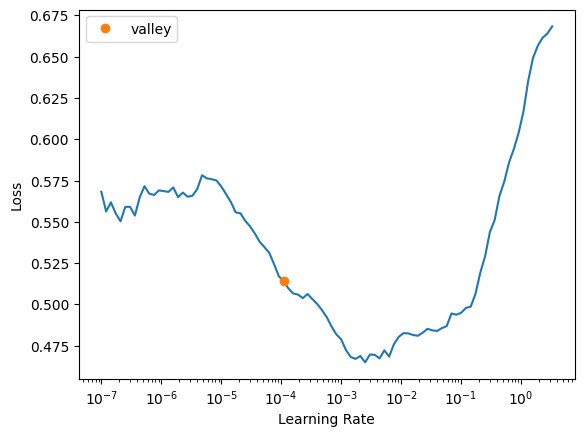

In [ ]:
learn_alpha.lr_find()

In [ ]:
with torch.no_grad():
    x,y = learn_alpha.dls.one_batch()
    x,y, = x.cuda(), y.cuda()
    pred = learn_alpha.model(x)
    l = learn_alpha.loss_func(pred,y)
print(torch.argwhere(torch.logical_not(torch.isfinite(x))))
print(l)

tensor([], device='cuda:0', size=(0, 3), dtype=torch.int64)
TensorBase(0.5310, device='cuda:0')


In [ ]:
learn_alpha.fit_one_cycle(2, lr_max=1e-4)

epoch,train_loss,valid_loss,time


In [ ]:
#learn_alpha.save(f'xresattn_alpha_{dim}d_varlen_relpolar_E2')

Path('/media/scratrch_data/gfernandez/STEProids/models/xresattn_alpha_2d_varlen_relpolar_E2.pth')

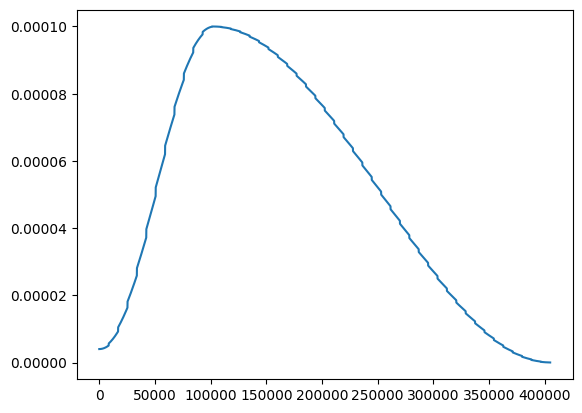

In [ ]:
plt.plot(learn.recorder.hps['lr']);

epoch,train_loss,valid_loss,time
0,0.246804,0.393671,01:29
1,0.252355,0.837968,01:29
2,0.225343,0.443131,01:29
3,0.223648,0.415640,01:30


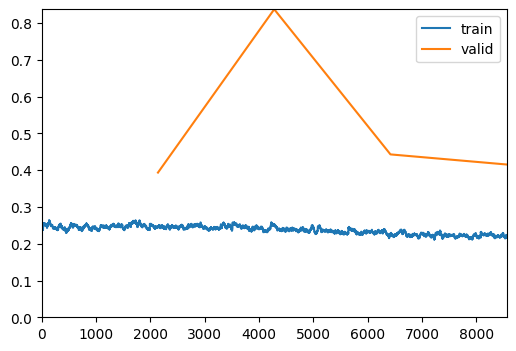

In [ ]:
learn_alpha.fit_one_cycle(4, lr_max=1e-4) # 0.27-0.235

In [ ]:
#learn_alpha.save(f'xresattn_alpha_{dim}d_varlen_relpolar_curated')

Path('/media/scratrch_data/gfernandez/STEProids/models/xresattn_alpha_2d_varlen_relpolar_curated.pth')

SuggestedLRs(valley=2.511886486900039e-05)

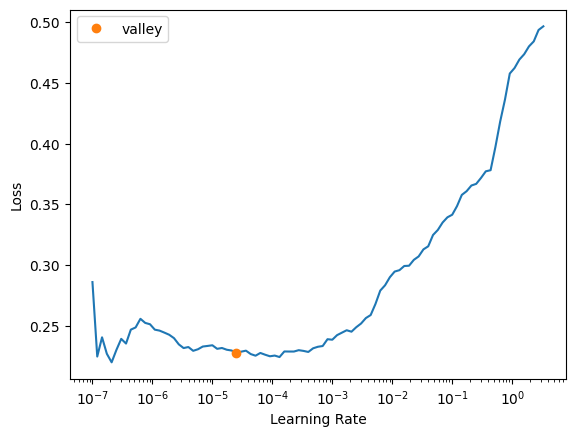

In [ ]:
learn_alpha.lr_find()

epoch,train_loss,valid_loss,time
0,0.214739,0.618920,01:29
1,0.224912,0.425534,01:29
2,0.222910,0.382891,01:31
3,0.219790,1.223955,01:30
4,0.211068,0.482534,01:29
5,0.216029,0.407256,01:29
6,0.209663,0.564762,01:29
7,0.194119,0.378117,01:29
8,0.202351,0.435899,01:30
9,0.188570,0.445066,01:30


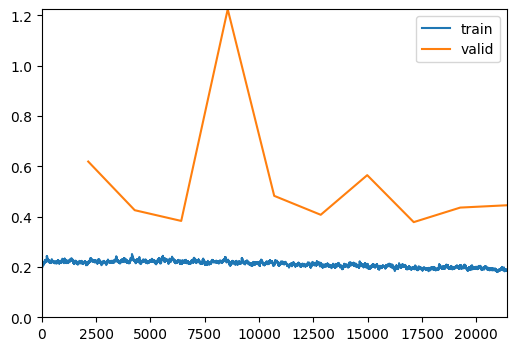

In [ ]:
learn_alpha.fit_one_cycle(10, lr_max=5e-5)

Finally, we can save the trained model.

In [ ]:
learn_alpha.save(f'xresattn_alpha_{dim}d_varlen_relpolar_curated_yrange_m01_21')

Path('/media/scratrch_data/gfernandez/STEProids/models/xresattn_alpha_2d_varlen_relpolar_curated_yrange_m01_21.pth')

In [ ]:
with torch.no_grad():
    x,y = learn_alpha.dls.valid.one_batch()
    pred = learn_alpha.model(x.cuda()).cpu()
    y = y.cpu()

In [ ]:
y.shape, pred.shape

(torch.Size([17, 453, 1]), torch.Size([17, 453, 1]))

  0%|          | 0/18 [00:00<?, ?it/s]

IndexError: index 17 is out of bounds for dimension 0 with size 17

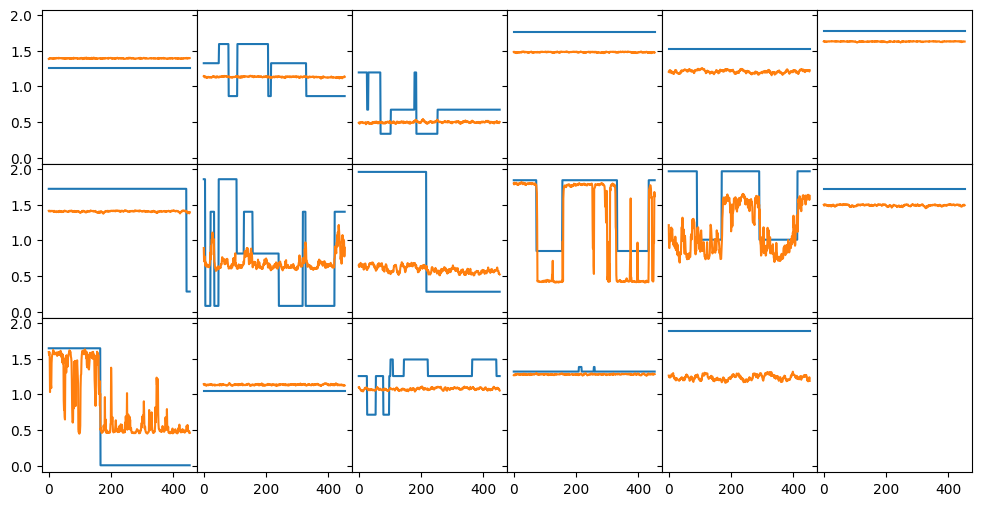

In [ ]:
n=3
fig, axs = plt.subplots(n,2*n, figsize=(12,6), 
                        sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0, hspace=0))
for i, ax in tenumerate(axs.flatten()):
    ax.plot(y[i]);ax.plot(pred[i]);

  0%|          | 0/18 [00:00<?, ?it/s]

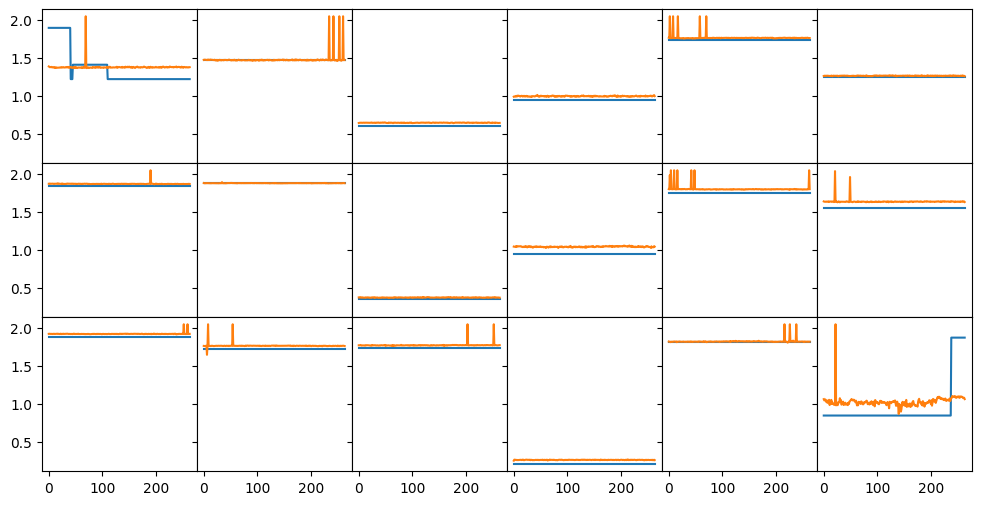

In [ ]:
n=3
fig, axs = plt.subplots(n,2*n, figsize=(12,6), 
                        sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0, hspace=0))
for i, ax in tenumerate(axs.flatten()):
    ax.plot(y[i]);ax.plot(pred[i]);

## Check Noise

In [ ]:
l_pred = []
l_y = []
l_mae = []
with torch.no_grad():
    for i, (x, y) in tenumerate(dls.valid):
        pred = learn.model(x).squeeze()
        mae = to_detach((pred-y).abs().mean(-1))
        pred = to_detach(pred)
        l_y.append(to_detach(y))
        l_pred.append(pred)
        l_mae.append(mae)

l_pred = torch.cat(l_pred)
l_mae = torch.cat(l_mae)
l_y = torch.cat(l_y)
l_pred.shape, l_mae.shape, l_y.shape

#Dtrue
x = l_y.numpy() #np.array([item[1].numpy() for item in dls.valid.dataset])
x_flat = x.reshape(-1)

# D_pred
y = l_pred.numpy()
y_flat = y.reshape(-1)

  0%|          | 0/79 [00:00<?, ?it/s]

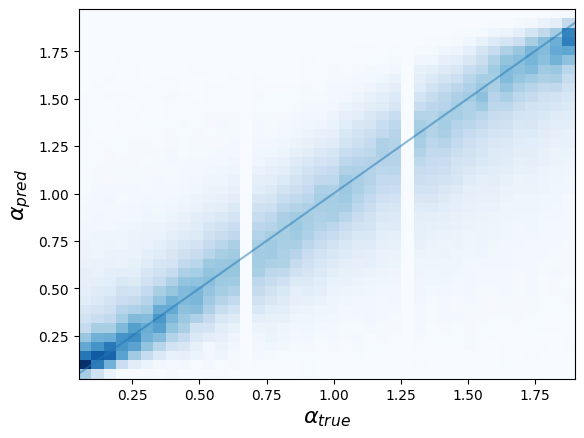

In [ ]:
plt.plot([0,2], [0,2], alpha=0.5);
plt.hist2d(x_flat,y_flat, 40, cmap='Blues', density=True,rasterized=True);
plt.ylabel(r'$\alpha_{pred}$', fontsize=16); plt.xlabel(r'$\alpha_{true}$', fontsize=16);

In [ ]:
ys = [item[1].numpy() for item in dls.valid.dataset]

In [ ]:
ys = np.array(ys)

In [ ]:
np.unique(ys) , np.unique(y_flat)

(array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 ,
        1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65,
        1.7 , 1.75, 1.8 , 1.85, 1.9 ], dtype=float32),
 array([0.01529703, 0.01576799, 0.01616013, ..., 1.9629476 , 1.9636447 ,
        1.9661801 ], dtype=float32))

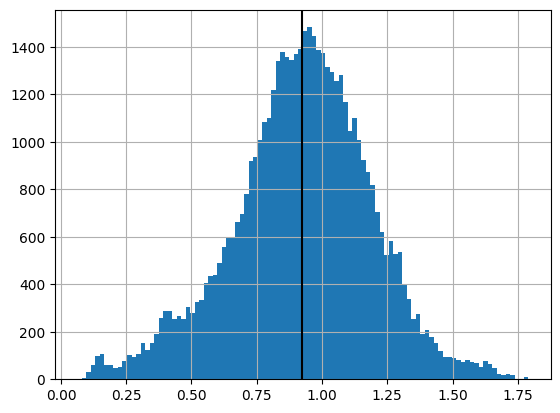

In [ ]:
plt.hist(y_flat[x_flat==1.], 100); plt.grid();
plt.axvline(y_flat[x_flat==1.].mean(), c='k');

In [ ]:
l_pred = []
l_y = []
l_mae = []
noise_std = 1
with torch.no_grad():
    for i, (x, y) in tenumerate(dls.valid):
        x = x + torch.normal(0,noise_std,size=x.shape, device=default_device())
        pred = learn.model(x).squeeze()
        mae = to_detach((pred-y).abs().mean(-1))
        pred = to_detach(pred)
        l_y.append(to_detach(y))
        l_pred.append(pred)
        l_mae.append(mae)

l_pred = torch.cat(l_pred)
l_mae = torch.cat(l_mae)
l_y = torch.cat(l_y)
l_pred.shape, l_mae.shape, l_y.shape

#Dtrue
x = l_y.numpy() #np.array([item[1].numpy() for item in dls.valid.dataset])
x_flat = x.reshape(-1)

# D_pred
y = l_pred.numpy()
y_flat = y.reshape(-1)

  0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
#sig2D
D_noise = noise_std**2/2*dim;
logD_noise = np.log10(D_noise)
D_noise, logD_noise

(1.0, 0.0)

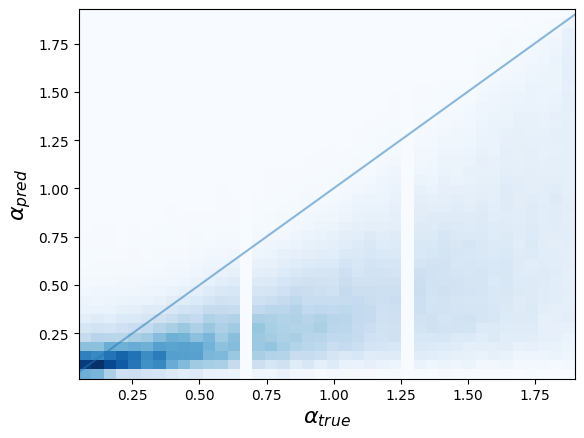

In [ ]:
plt.plot([-6,2], [-6,2], alpha=0.5);
plt.hist2d(x_flat,y_flat, 40, cmap='Blues', density=True,rasterized=True);
plt.ylabel(r'$\alpha_{pred}$', fontsize=16); plt.xlabel(r'$\alpha_{true}$', fontsize=16);
plt.axhline(logD_noise, alpha=0.5);plt.axvline(logD_noise, alpha=0.5);

In [ ]:
l_pred = []
l_y = []
l_mae = []
noise_std = 0.1
with torch.no_grad():
    for i, (x, y) in tenumerate(dls.valid):
        x = x + torch.normal(0,noise_std,size=x.shape, device=default_device())
        pred = learn.model(x).squeeze()
        mae = to_detach((pred-y).abs().mean(-1))
        pred = to_detach(pred)
        l_y.append(to_detach(y))
        l_pred.append(pred)
        l_mae.append(mae)

l_pred = torch.cat(l_pred)
l_mae = torch.cat(l_mae)
l_y = torch.cat(l_y)
l_pred.shape, l_mae.shape, l_y.shape

#Dtrue
x = l_y.numpy() #np.array([item[1].numpy() for item in dls.valid.dataset])
x_flat = x.reshape(-1)

# D_pred
y = l_pred.numpy()
y_flat = y.reshape(-1)

  0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
#sig2D
D_noise = noise_std**2/2*dim;
logD_noise = np.log10(D_noise)
D_noise, logD_noise

(0.010000000000000002, -2.0)

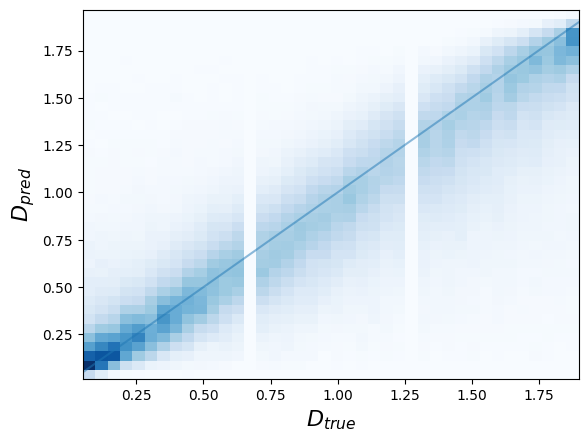

In [ ]:
plt.plot([-6,2], [-6,2], alpha=0.5);
plt.hist2d(x_flat,y_flat, 40, cmap='Blues', density=True,rasterized=True);
plt.ylabel(r'$D_{pred}$', fontsize=16); plt.xlabel(r'$D_{true}$', fontsize=16);
plt.axhline(logD_noise, alpha=0.5);plt.axvline(logD_noise, alpha=0.5);

In [ ]:
l_pred = []
l_y = []
l_mae = []
noise_std = 0.01
with torch.no_grad():
    for i, (x, y) in tenumerate(dls.valid):
        x = x + torch.normal(0,noise_std,size=x.shape, device=default_device())
        pred = learn.model(x).squeeze()
        mae = to_detach((pred-y).abs().mean(-1))
        pred = to_detach(pred)
        l_y.append(to_detach(y))
        l_pred.append(pred)
        l_mae.append(mae)

l_pred = torch.cat(l_pred)
l_mae = torch.cat(l_mae)
l_y = torch.cat(l_y)
l_pred.shape, l_mae.shape, l_y.shape

#Dtrue
x = l_y.numpy() #np.array([item[1].numpy() for item in dls.valid.dataset])
x_flat = x.reshape(-1)

# D_pred
y = l_pred.numpy()
y_flat = y.reshape(-1)

  0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
#sig2D D = sigma**2/2 * dim =(2D)= sigma**2
D_noise = noise_std**2/2*dim;
logD_noise = np.log10(D_noise)
D_noise, logD_noise

(0.0001, -4.0)

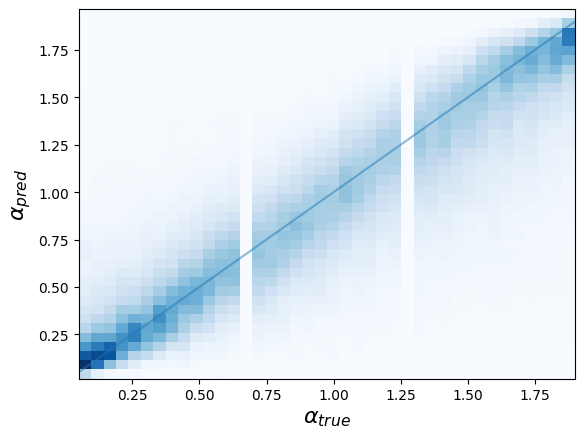

In [ ]:
plt.plot([-6,2], [-6,2], alpha=0.5);
plt.hist2d(x_flat,y_flat, 40, cmap='Blues', density=True,rasterized=True);
plt.ylabel(r'$\alpha_{pred}$', fontsize=16); plt.xlabel(r'$\alpha_{true}$', fontsize=16);
plt.axhline(logD_noise, alpha=0.5);plt.axvline(logD_noise, alpha=0.5);

# D

In [ ]:
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/baby/track_2/trajectories.npz")
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/medium_0/track_2/trajectories_c.npz")
#data_path = Path("/media/scratrch_data/nanoninjas/data/raw/medium_1/track_2/trajectories_c.npz")
bs_ = 400*20
dls = get_dls_array(data_path, bs_, target=1, drop_last=True)
dim = 2

In [ ]:
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/big22/track_2/")
bs_ = 800*20
dls = get_big_dls_array(data_path, bs_, target=1, split_pct=0.05, drop_last=True)
dim = 2

  0%|          | 0/580 [00:00<?, ?it/s]

Loaded


  0%|          | 0/580 [00:00<?, ?it/s]

Log10-transformed D and dr


In [ ]:
bs_

16000

In [ ]:
100*200

20000

In [ ]:
b = dls.train.dataset[-2]#.one_batch()

In [ ]:
b[0].shape, #b[0].device, b[1].shape

((26, 598, 2),)

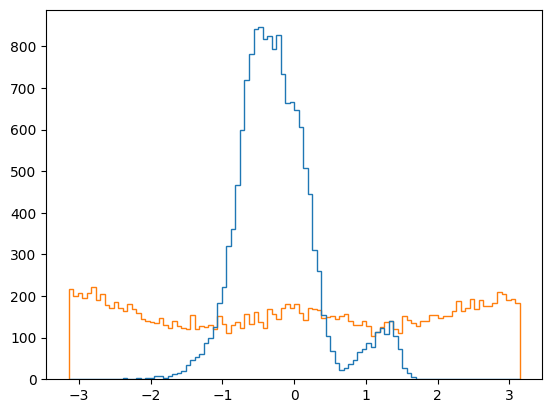

In [ ]:
plt.hist(b[0].reshape(-1,2), 100, histtype='step');

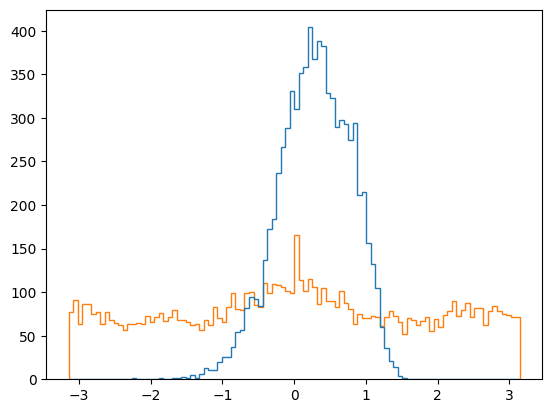

In [ ]:
plt.hist(b[0].reshape(-1,2).numpy(), 100, histtype='step');

In [ ]:
b[0].shape, b[0].device, b[1].shape

(torch.Size([20, 387, 2]), device(type='cpu'), torch.Size([20, 387, 1]))

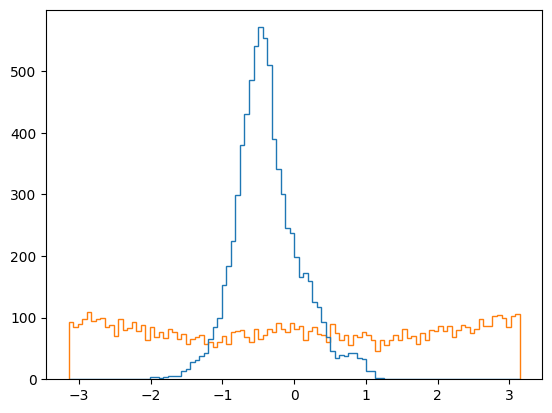

In [ ]:
plt.hist(b[0].reshape(-1,2).numpy(), 100, histtype='step');

In [ ]:
Normalization??

Init signature: Normalization(dim=-1)
Source:        
class Normalization(Module):
    "Z-Normalization over the designated dimension."
    def __init__(self, dim=-1): self.dim = dim
    def forward(self, x): 
        return (x - x.mean(self.dim).unsqueeze(self.dim))/x.std(self.dim).unsqueeze(self.dim)
File:           ~/Downloads/step/step/models.py
Type:           PrePostInitMeta
Subclasses:     

In [ ]:
LogXResAttn??

Init signature:
LogXResAttn(
    dim,
    n_class=5,
    conv_blocks=[1, 1],
    block=<class 'fastai.layers.ResBlock'>,
    block_szs=[64, 128],
    nhead_enc=1,
    n_encoder_layers=6,
    dim_ff=2048,
    dropout=0.1,
    pos_enc=True,
    linear_layers=[128],
    activation='relu',
    norm=True,
    yrange=(0, 2.05),
    **kwargs,
)
Source:        
class LogXResAttn(XResAttn):
    "Xresnet blocks with attention at the end. t takes the logarithm of the displacements."

    def forward(self, x, use_mask=False, src_mask=None, src_key_padding_mask=None):
        x = torch.clamp(x[:, 1:] - x[:, :-1], min=1e-8)
        x = x.sign()*x.abs().log()
        x = self.norm(x)
        x = self.convs(x.transpose(2, 1)).transpose(2, 1)
        src = self.pos_enc(x.transpose(1, 0))
        if use_mask and src_mask is None: src_mask = self.get_random_mask(src.shape[0])
        out_enc = self.encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        return self.act(self.linear(

In [ ]:
with default_device():
    model = XResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1],
                 block_szs=[128, 256, 512], dropout=0., pos_enc=False, 
                 n_encoder_layers=4, dim_ff=512, nhead_enc=8,
                 linear_layers=[], norm=False, yrange=(-6.5, 2.5))

In [ ]:
class MSLEDMetric(AvgMetric):
    """Metric to log the MSLE"""
    def __init__(self,): pass#super().__init__()
    def accumulate(self, learn):
        bs = find_bs(learn.yb)
        pred = to_detach(learn.pred)
        MSLE = (torch.log(torch.pow(10,learn.pred)+1) - torch.log(torch.pow(10,learn.y)+1))**2
        MSLE = MSLE.mean()
        self.total += MSLE*bs
        self.count += bs
    @property
    def name(self):  return 'msle'

In [ ]:
# diffusion coefficient model
with default_device():
    model_log_D = XResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1],
                 block_szs=[128, 256, 512], dropout=0., pos_enc=False, 
                 n_encoder_layers=4, dim_ff=512, nhead_enc=8,
                 linear_layers=[], norm=False, yrange=(-10.5,4.5))#(-10.1, 2.1))
    learn_log_D = Learner(dls, model_log_D, loss_func=MSELossFlat(), model_dir=MODEL_PATH,
                         cbs=[ShowGraphCallback()], metrics=[MSLEDMetric()])
    
    model_log_D_path = Path('/media/scratrch_data/gfernandez/STEProids/models/xresattn_2d_varlen_relpolar_log10r')
    # model_log_D_path = model_log_D_path.with_name('xresattn_2d_varlen_relpolar_log10r_curated')
    # model_log_D_path = model_log_D_path.with_name('xresattn_2d_varlen_relpolar_log10r_curated_01')
    model_log_D_path = model_log_D_path.with_name('xresattn_2d_varlen_relpolar_log10r_yrange_m65_25_big17E2')
    
    learn_log_D.load(model_log_D_path, device=default_device())
    model_log_D_name = model_log_D_path.name
    # learn_log_D.model.eval();

In [ ]:
learn_log_d = learn_log_D

Finally, we put all together in a `Learner`. We will use the mean absolute error loss, or $L_1$ loss and the Adam optimizer (default option in the learner).

In [ ]:
AvgMetric??

Init signature: AvgMetric(func)
Source:        
class AvgMetric(Metric):
    "Average the values of `func` taking into account potential different batch sizes"
    def __init__(self, func):  self.func = func
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)
        self.total += learn.to_detach(self.func(learn.pred, *learn.yb))*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count if self.count != 0 else None
    @property
    def name(self):  return self.func.func.__name__ if hasattr(self.func, 'func') else  self.func.__name__
File:           ~/miniforge3/envs/step/lib/python3.11/site-packages/fastai/learner.py
Type:           type
Subclasses:     LossMetric

In [ ]:
metrics = [MSLEDMetric()]

In [ ]:
cbs = ShowGraphCallback()

In [ ]:
learn_log_d = Learner(dls, model, loss_func=MSELossFlat(),#L1LossFlat(),
                      model_dir=MODEL_PATH,
                cbs=cbs, metrics=metrics)

A rather handy functionality of the learner is the `lr_find` method. This function trains the model for a few mini-batches changing the learning rate. Then, we can visualize the loss and determine the regions where the model is learning, where the learning rate is too low and where it diverges.

In [ ]:
learn_log_d.summary()

XResAttn (Input shape: 136 x 116 x 2)
Layer (type)         Output Shape         Param #    Trainable 
                     136 x 64 x 116      
Conv1d                                    384        True      
BatchNorm1d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     136 x 128 x 116     
Conv1d                                    24576      True      
BatchNorm1d                               256        True      
ReLU                                                           
Conv1d                                    49152      True      
BatchNorm1d                               256        True      
Conv1d                                    8192       True      
BatchNorm1d                               256        True      
ReLU                                                           
_________________________________

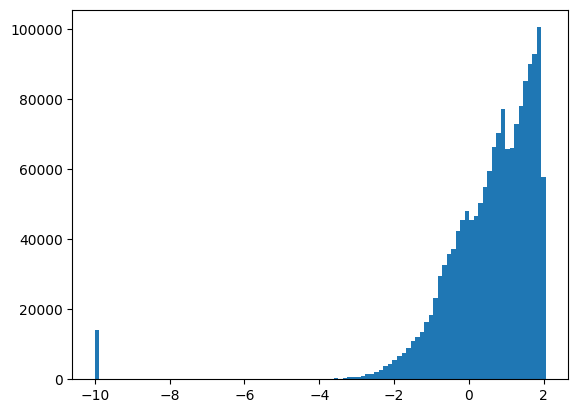

In [ ]:
plt.hist(learn_log_d.dls.train.dataset.trajs['20'][...,3:4].reshape(-1), 100);#plt.xscale('log');

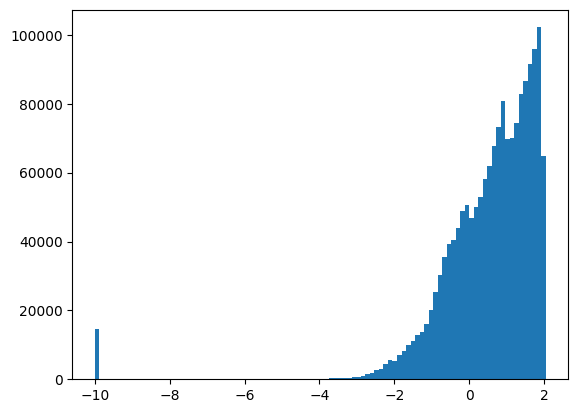

In [ ]:
plt.hist(learn_log_d.dls.train.dataset.trajs['21'][...,3:4].reshape(-1), 100);

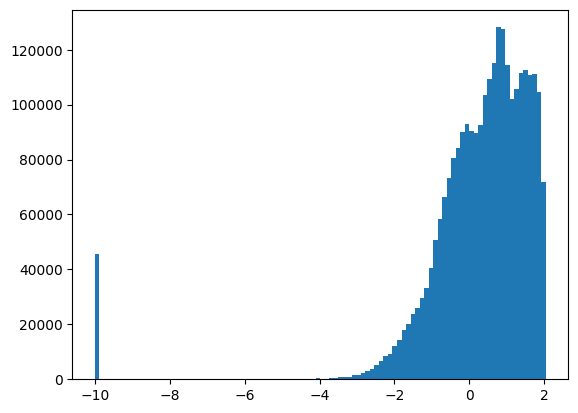

In [ ]:
plt.hist(learn_log_d.dls.train.dataset.trajs['40'][...,3:4].reshape(-1), 100);

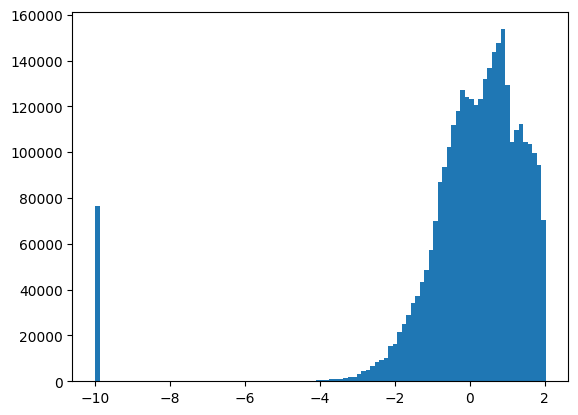

In [ ]:
plt.hist(learn_log_d.dls.train.dataset.trajs['60'][...,3:4].reshape(-1), 100);

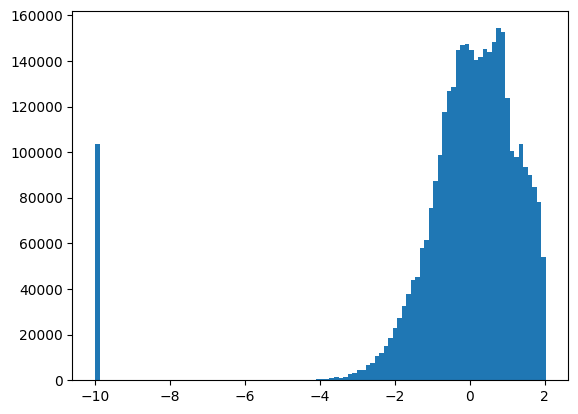

In [ ]:
plt.hist(learn_log_d.dls.train.dataset.trajs['80'][...,3:4].reshape(-1), 100);

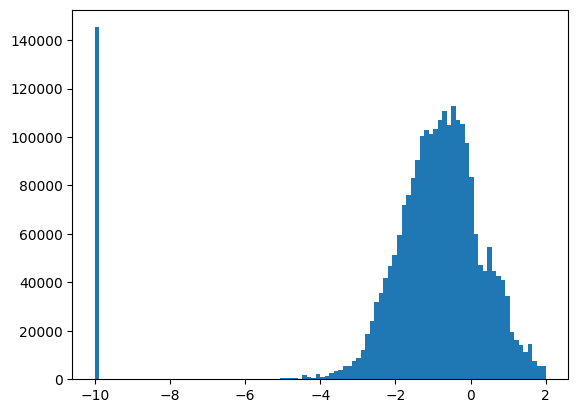

In [ ]:
plt.hist(learn_log_d.dls.train.dataset.trajs['400'][...,3:4].reshape(-1), 100);

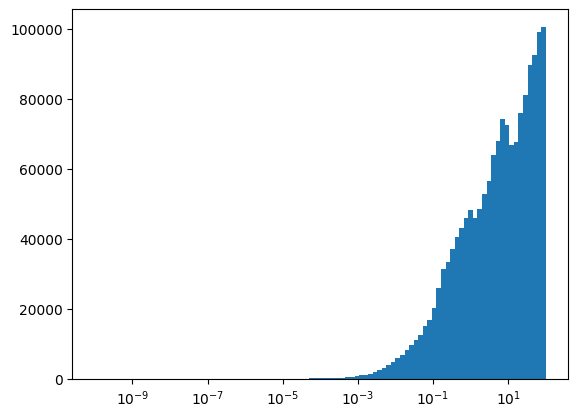

In [ ]:
plt.hist(learn_log_d.dls.train.dataset.trajs['20'][...,3:4].reshape(-1), np.geomspace(1e-10,1e2,100));plt.xscale('log');

Small trajectories have a lot of examples in big Ds. All histograms seem to be cut at max D=2.
Model collapse to max D=2 might be because of low lr???

SuggestedLRs(valley=0.00015848931798245758)

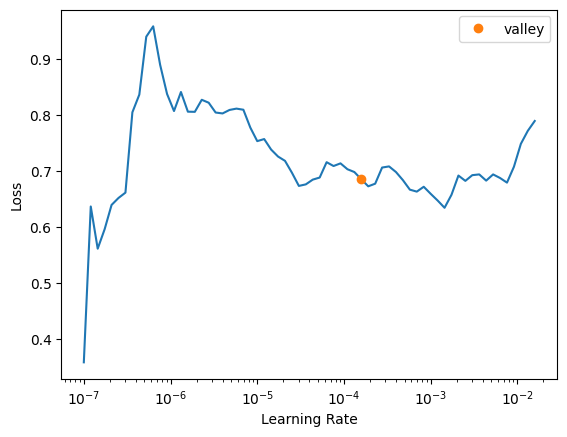

In [ ]:
learn_log_d.lr_find()

In [ ]:
with torch.no_grad():
    x,y = learn_log_d.dls.valid.one_batch()
    x,y = x.cuda(), y.cuda()
    pred = learn_log_d.model(x)
    l = learn_log_d.loss_func(pred,y)

print(torch.argwhere(torch.logical_not(torch.isfinite(x))))
print(torch.argwhere(torch.logical_not(torch.isfinite(y))))

print(l)

tensor([], device='cuda:0', size=(0, 3), dtype=torch.int64)
tensor([], device='cuda:0', size=(0, 3), dtype=torch.int64)
TensorBase(0.8315, device='cuda:0')


In [ ]:
# check there are no nans in the dataset
for i,t in tenumerate(learn_log_d.dls.valid.dataset):
    if np.any(np.logical_not(np.isfinite(t[0]))): print(i)
    if np.any(np.logical_not(np.isfinite(t[1]))): print(1,i)

  0%|          | 0/81368 [00:00<?, ?it/s]

This is a typical shape where we have a regime where the model is not learning, followed by a fast-learning regime (slope downhill) and then a divergence region. We usually take a learning rate that is about 10x below the valley.

Then we train with `fit_one_cycle`, which follows the [one-cycle policy](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/11006/1100612/Super-convergence--very-fast-training-of-neural-networks-using/10.1117/12.2520589.short). We typically train with a few epochs and, if we see the model is still learning and not overfitting, we resume the training. 

In [ ]:
learn_log_d.fit_one_cycle(2, lr_max=1e-4)

epoch,train_loss,valid_loss,msle,time


In [ ]:
learn_log_d.save(f'xresattn_{dim}d_varlen_relpolar_log10r_yrange_m105_45_big22E2')

Path('/media/scratrch_data/gfernandez/STEProids/models/xresattn_2d_varlen_relpolar_log10r_yrange_m105_45_big22E2.pth')

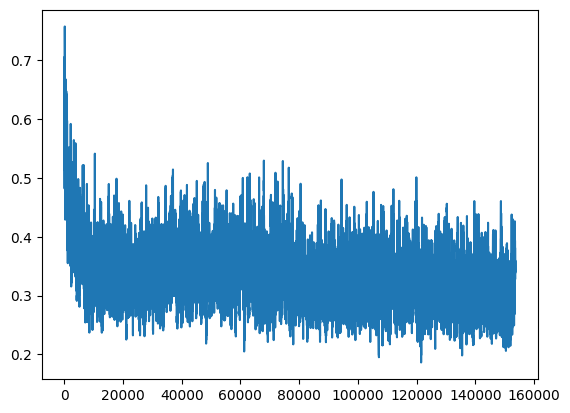

In [ ]:
plt.plot(learn_log_d.recorder.losses[1000:]);

epoch,train_loss,valid_loss,msle,time
0,0.793364,28.195923,2.940793,1:56:36
1,0.695841,0.654477,0.200310,1:56:24


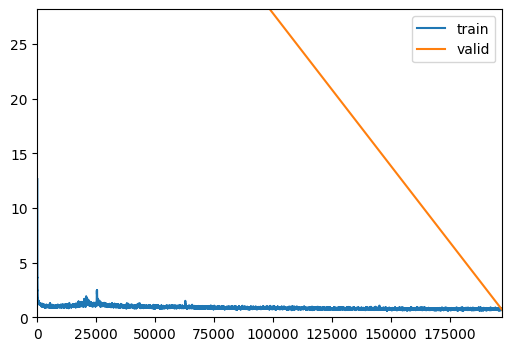

In [ ]:
learn_log_d.fit_one_cycle(2, lr_max=1e-3)

In [ ]:
learn_log_d.save(f'xresattn_{dim}d_varlen_relpolar_log10r_yrange_m65_25_big17E2')

Path('/media/scratrch_data/gfernandez/STEProids/models/xresattn_2d_varlen_relpolar_log10r_yrange_m65_25_big17E2.pth')

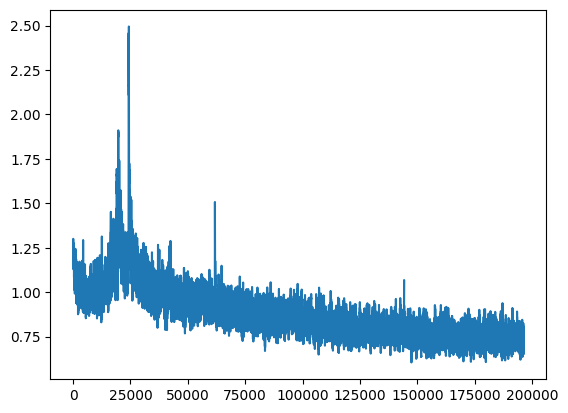

In [ ]:
plt.plot(learn_log_d.recorder.losses[1000:]);

epoch,train_loss,valid_loss,msle,time
0,0.513816,1.874775,0.809295,01:13
1,0.501882,4.492730,0.709154,01:13
2,0.477189,4.024838,0.709123,01:14
3,0.512946,4.526837,0.709154,01:13
4,0.480984,0.662569,0.083236,01:13
5,0.479259,0.376117,0.031607,01:13


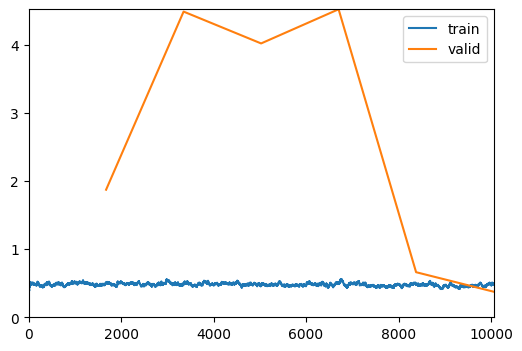

In [ ]:
learn_log_d.fit_one_cycle(6, lr_max=2e-4)

epoch,train_loss,valid_loss,msle,time
0,0.490534,0.422426,0.026937,01:14
1,0.497233,0.543520,0.038231,01:14
2,0.487230,1.374708,0.231054,01:14
3,0.482090,1.519908,0.284775,01:14
4,0.446478,0.500908,0.029839,01:14
5,0.464740,0.951923,0.167820,01:14
6,0.471127,0.549599,0.029430,01:14
7,0.426078,0.456998,0.039027,01:14
8,0.432550,0.372288,0.021378,01:14
9,0.465758,0.406967,0.021831,01:14


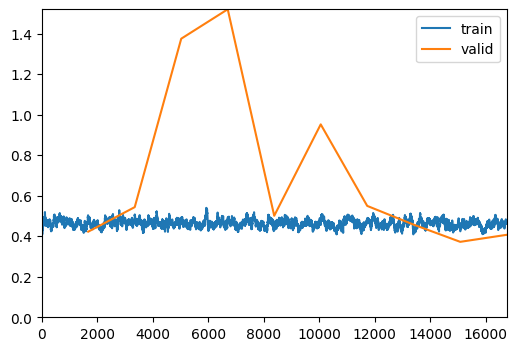

In [ ]:
learn_log_d.fit_one_cycle(10, lr_max=1e-5)

In [ ]:
learn_log_d.save(f'xresattn_{dim}d_varlen_relpolar_log10r_curated')

Path('/media/scratrch_data/gfernandez/STEProids/models/xresattn_2d_varlen_relpolar_log10r_curated.pth')

epoch,train_loss,valid_loss,msle,time
0,0.802087,0.641235,0.055361,06:00
1,0.731066,0.600708,0.036705,06:00
2,0.596168,0.459085,0.044790,05:56
3,0.584570,0.682028,0.063349,05:55
4,0.564181,1.432414,0.185936,05:59
5,0.561828,1.218738,0.162276,05:56
6,0.582441,1.741496,0.269400,05:55
7,0.620329,1.580544,0.246717,05:55
8,0.576579,1.739216,0.287728,05:58
9,0.551544,1.900466,0.333434,05:56


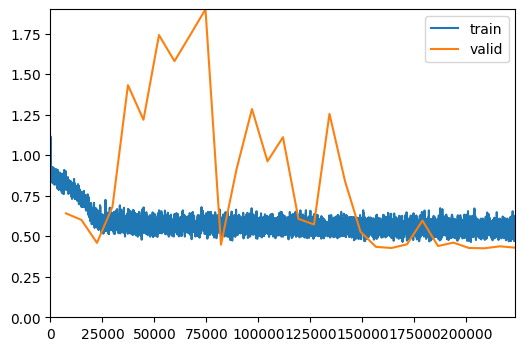

In [ ]:
learn_log_d.fit_one_cycle(30, lr_max=2e-5)

In [ ]:
learn_log_d.save(f'xresattn_{dim}d_varlen_relpolar_log10r_curated_01')

Path('/media/scratrch_data/gfernandez/STEProids/models/xresattn_2d_varlen_relpolar_log10r_curated_01.pth')

epoch,train_loss,valid_loss,msle,time
0,2.282907,2.293438,1.243531,01:18
1,1.340975,1.396834,0.704585,01:16
2,1.154194,1.701633,0.504191,01:17
3,1.452140,1.218898,0.339633,01:17
4,1.104206,1.394933,0.097133,01:17
5,1.177485,0.861808,0.044382,01:18
6,1.247400,0.896603,0.058178,01:17
7,1.083704,0.920591,0.128183,01:17
8,1.063489,0.848770,0.051592,01:17
9,1.166308,0.844959,0.026680,01:18


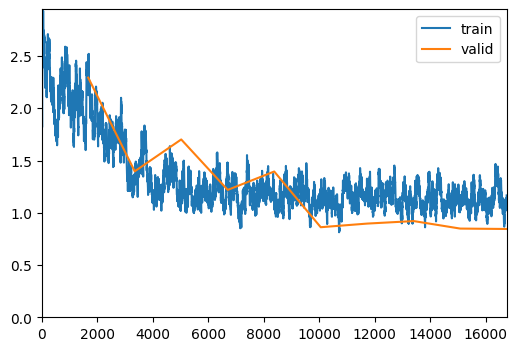

In [ ]:
learn_log_d.fit_one_cycle(10, lr_max=1e-5)

epoch,train_loss,valid_loss,msle,time
0,1.175184,0.868490,0.073214,01:15
1,1.127183,0.878685,0.059272,01:18
2,1.089595,1.289690,0.134996,01:17
3,1.071834,1.628380,0.104242,01:18
4,1.009631,2.094718,0.288336,01:19
5,1.047764,1.940643,0.206523,01:18
6,1.068137,4.767019,0.512347,01:18
7,1.069738,4.097569,0.961467,01:18
8,1.159560,1.881239,0.320327,01:17
9,1.071140,1.822884,0.290650,01:18


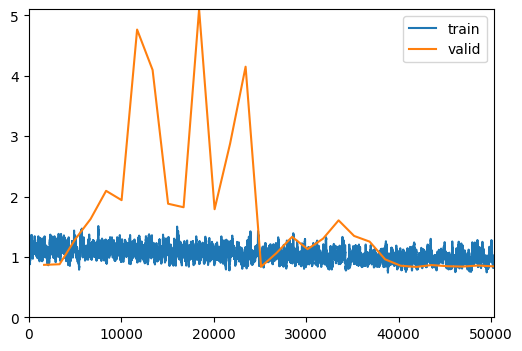

In [ ]:
learn_log_d.fit_one_cycle(30, lr_max=2e-5)

In [ ]:
learn_log_d.save(f'xresattn_{dim}d_varlen_relpolar_log10r_curated_MSE')

Path('/media/scratrch_data/gfernandez/STEProids/models/xresattn_2d_varlen_relpolar_log10r_curated_MSE.pth')

In [ ]:
learn_log_d.lr

0.001

In [ ]:
x

tensor([[[ 0.7467,  0.0000],
         [ 0.9352,  1.5910],
         [-0.2416, -1.2559],
         ...,
         [ 0.2272,  0.0409],
         [ 1.0547,  1.1752],
         [ 0.2227, -2.5354]],

        [[-0.6262,  0.0000],
         [-0.6335, -1.9459],
         [-1.2197,  0.9016],
         ...,
         [-1.3381,  3.1308],
         [-1.1621, -1.8469],
         [-0.3902,  1.9190]],

        [[-0.4241,  0.0000],
         [-0.9837, -1.4903],
         [-0.7630, -2.0252],
         ...,
         [-0.7169, -2.4316],
         [-0.3263, -2.9329],
         [-0.4666, -2.9116]],

        ...,

        [[ 0.9413,  0.0000],
         [ 0.6068,  1.2950],
         [ 0.9523, -1.3328],
         ...,
         [ 0.2709, -2.8930],
         [ 0.9957, -2.7561],
         [ 0.5601,  2.6055]],

        [[-0.6069,  0.0000],
         [-0.5639,  2.1569],
         [-1.0043, -0.4602],
         ...,
         [-0.9406,  2.6344],
         [-0.6399, -2.1156],
         [-0.8897, -0.4086]],

        [[ 0.8133,  0.0000],
       

In [ ]:
with torch.no_grad():
    x,y = learn_log_d.dls.one_batch()
    pred = learn_log_d.model(x.cuda()).cpu()
    y = y.cpu()

In [ ]:
y.shape, pred.shape

(torch.Size([18, 440, 1]), torch.Size([18, 440, 1]))

In [ ]:
pred = pred.cpu()
y = y.cpu()

  0%|          | 0/18 [00:00<?, ?it/s]

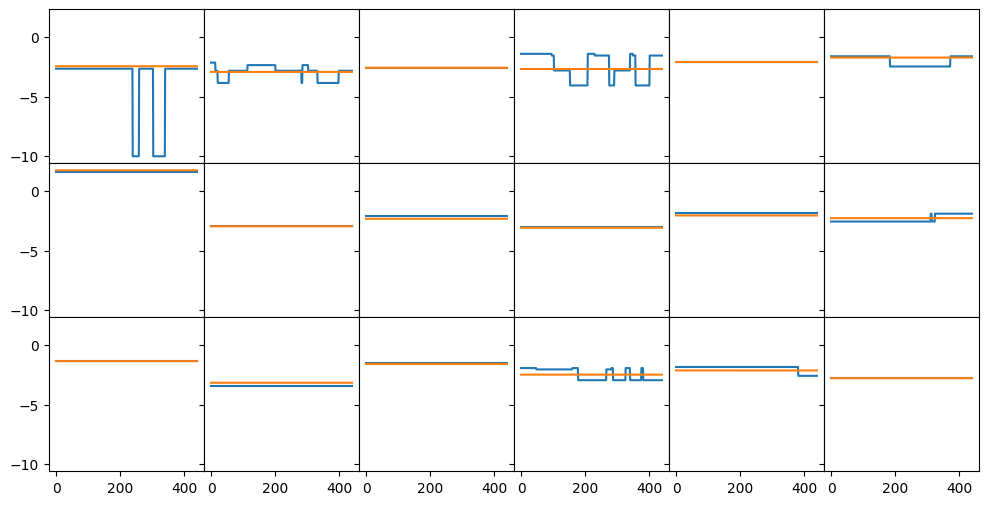

In [ ]:
n=3
fig, axs = plt.subplots(n,2*n, figsize=(12,6), 
                        sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0, hspace=0))
for i, ax in tenumerate(axs.flatten()):
    ax.plot(y[i]);ax.plot(pred[i]);

  0%|          | 0/18 [00:00<?, ?it/s]

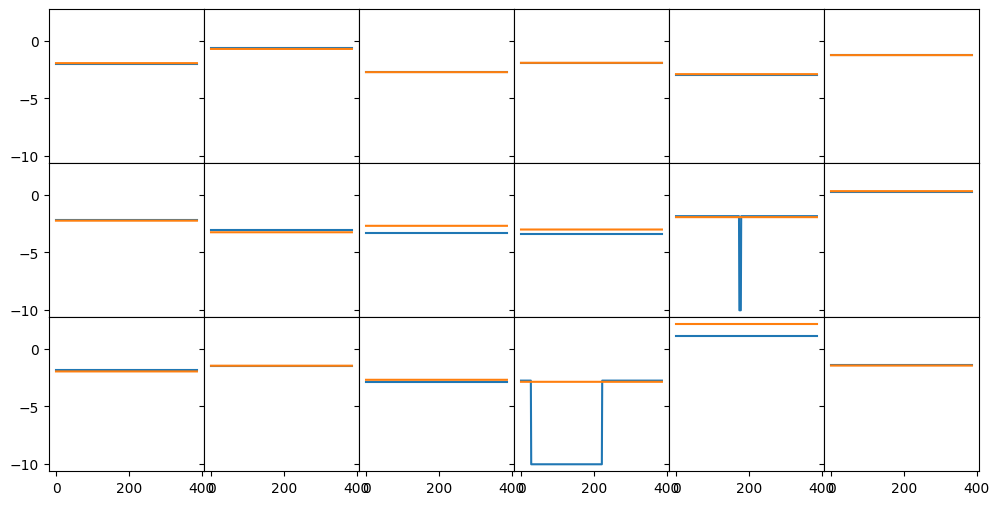

In [ ]:
n=3
fig, axs = plt.subplots(n,2*n, figsize=(12,6), 
                        sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0, hspace=0))
for i, ax in tenumerate(axs.flatten()):
    ax.plot(y[i]);ax.plot(pred[i]);

Finally, we can save the model.

In [ ]:
learn_log_d.save(f'xresattn_{dim}d_varlen_relpolar_log10r_curated')

Path('/media/scratrch_data/gfernandez/STEProids/models/xresattn_2d_varlen_relpolar_log10r_curated.pth')

In [ ]:
# learn.save(f'logxresattn_bm_{dim}d_1_to_4_cp')

Path('/media/scratch_data/gfernandez/models/logxresattn_bm_2d_1_to_4_cp.pth')

## Get the predictions

We now perform the predictions of the trajectories as a whole and store them in the dataframe to process them later.

In [ ]:
for i, (x, y) in tenumerate(dls.valid):
    pred = to_detach(learn.model(x).squeeze())
    mae = to_detach((learn.model(x).squeeze()-y).abs().mean(-1))
    l_pred = np.array([p for p in pred], dtype=object)
    ds.loc[i*bs:(i+1)*bs-1, 'mae']  = mae.numpy()
    ds.loc[i*bs:(i+1)*bs-1, 'pred'] = l_pred

  0%|          | 0/75 [00:00<?, ?it/s]

/tmp/ipykernel_1564048/1888903365.py:4: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  l_pred = np.array([p for p in pred], dtype=object)


With the full-trajectory predictions, we can proceed to perform the segment-wise analysis. We split the trajectories and their predictions by the *true* changepoints. Then, we perform the prediction especifically for each segment with both the model and the TA-MSD method. We choose the TA-MSD 1-2 to perform the evaluation, which is optimal for Brownian motion.

Let's define a prediction function to simplify the code.

In [ ]:
def predict_sample(model, x):
    xb = x.unsqueeze(0).to(default_device())
    return to_detach(model(xb).squeeze())

Now we can proceed to process the trajectories. The following piece of code is rather chonky so let us give a brief overview. For every trajectory (outer loop), we process each of its segments (inner loop). For every segment, we compute the mean absolute error (MAE) and the mean relative error with the three aforementioned approaches.

In [ ]:
segment_data = []

for i, row in tqdm(ds.iterrows()):
    x, y,= row.x, torch.log10(row.y_exp.squeeze())
    y = y[...,1:] # to coincide with full input prediction
    pred, cps = row.pred, row.cp
    split_x = split_tensor(x.T, cps)
    split_y, split_pred = split_tensor(y, cps-1), split_tensor(pred, cps-1)
    
    splits = zip(split_x, split_y, split_pred)
    for j, (seg_x, seg_y, pred_cut) in enumerate(splits):
        # Prediction over full trajectory cut with true changepoints
        mae = mean_absolute_error(pred_cut, seg_y)
        rel_err = mean_relative_error(pred_cut, seg_y)
        
        # Prediction over segment
        pred_segment = predict_sample(learn.model, seg_x - seg_x[0])
        if j==0:
            mae_segment = mean_absolute_error(pred_segment, seg_y)
            rel_err_segment = mean_relative_error(pred_segment, seg_y)
        else:
            mae_segment = mean_absolute_error(pred_segment, seg_y[...,1:])
            rel_err_segment = mean_relative_error(pred_segment, seg_y[...,1:])
        
        # Prediction over segment with TA-MSD
        pred_tamsd = diffusion_coefficient_tamsd(seg_x)
        mae_tamsd = mean_absolute_error(pred_tamsd, 10**seg_y[0])
        rel_err_tamsd = (pred_tamsd*10**(-seg_y[0]) - 1).abs()
        
        # Save the segment metrics
        segment_data.append({'sample': i, 'segment_idx': j,
                             'length': len(seg_y), 'x': seg_x, 'y': seg_y,
                             'pred_cut': pred_cut,
                             'pred_segment': pred_segment,
                             'pred_tamsd': pred_tamsd, 'mae': mae,
                             'rel_err': rel_err, 'mae_segment': mae_segment,
                             'rel_err_segment': rel_err_segment,
                             'mae_tamsd': mae_tamsd,
                             'rel_err_tamsd': rel_err_tamsd})
segment_ds = pd.DataFrame.from_records(segment_data)

0it [00:00, ?it/s]

TypeError: object of type 'float' has no len()

In [ ]:
segment_ds = pd.DataFrame.from_records(segment_data)

Finally, we save all the data for its posterior post-processing. It is extremely heavy and slow :D

In [ ]:
segment_ds.to_pickle(DATA_PATH/"segment_analysis_test.pkl")

## Overall performance

To obtain an intuition of our model's performance, we can do a qualitative analysis by looking at the predicted diffusion coefficient $D_{\text{pred}}$ as function of the ground truth $D_{\text{true}}$ at every time step.

To do so, we simply concatenate the predictions for every segment `segment_ds.pred_cut` and their true labels `segment_ds.y`.

In [ ]:
true = np.concatenate([*segment_ds.y])
pred = np.concatenate([*segment_ds.pred_cut])

Now we can build the 2D histogram.

In [ ]:
bins = [np.linspace(-3, 3, 61), np.linspace(-3.1, 3.1, 63)]
hist, true_edges, pred_edges = np.histogram2d(true, pred, bins=bins)

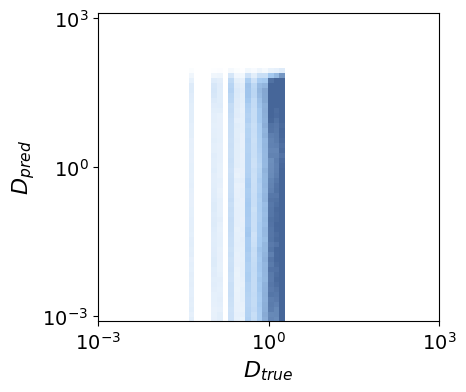

In [ ]:
#| code-fold: true
fig = plt.figure(figsize=(1.1*fig_size, fig_size))
plt.pcolor(hist.transpose()/hist.max(), cmap=cmap_hist1, vmax=0.8, rasterized=True)
xtick_pos = np.linspace(0, len(true_edges) - 1, np.ceil(len(true_edges)/30).astype(int))
xtick_labels = [fr'$10^{{{i:.0f}}}$' for i in true_edges[::30]]
ytick_pos = np.linspace(0, len(pred_edges) - 3, np.ceil(len(pred_edges)/30).astype(int)) + 1
ytick_labels = [fr'$10^{{{i:.0f}}}$' for i in pred_edges[1::30]]
plt.yticks(ytick_pos, labels=ytick_labels)
plt.ylabel(r'$D_{pred}$', fontsize=16)
plt.xticks(xtick_pos, xtick_labels)
plt.xlabel(r'$D_{true}$', fontsize=16)
plt.tick_params(labelsize=14)

# States

In [ ]:
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/baby/track_2/trajectories.npz")
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/medium_0/track_2/trajectories.npz")
bs_ = 400*20
dls = get_dls_array(data_path, bs_, drop_last=True)
dim = 2

In [ ]:
dls.one_batch()

(tensor([[[ 70.3909,  41.8874],
          [ 70.3553,  41.5703],
          [ 70.3550,  41.7993],
          ...,
          [ 72.0189,  32.4233],
          [ 71.6619,  32.3257],
          [ 71.1350,  31.9903]],
 
         [[ 76.9811,  95.5097],
          [ 77.5223,  95.9003],
          [ 78.0517,  95.7964],
          ...,
          [ 73.4574,  90.6983],
          [ 73.2154,  90.1836],
          [ 72.9071,  90.1668]],
 
         [[ 74.2606, 143.6983],
          [ 73.8048, 143.1150],
          [ 73.9585, 142.4919],
          ...,
          [170.4629,  33.1445],
          [170.6948,  32.4983],
          [171.3100,  32.1929]],
 
         ...,
 
         [[ 99.4024,  44.5394],
          [ 99.8210,  44.3120],
          [ 99.8700,  44.3122],
          ...,
          [102.1862,  39.9715],
          [101.9827,  40.1756],
          [102.0518,  40.1051]],
 
         [[188.7316,  54.6289],
          [189.0118,  55.5412],
          [188.9743,  56.4326],
          ...,
          [190.3491, 103.3498],
 

In [ ]:
with default_device():
    model = XResAttn(dim, n_class=4, stem_szs=(32,), conv_blocks=[1, 1, 1],
                 block_szs=[128, 256, 512], dropout=0., pos_enc=False, n_encoder_layers=4,
                 dim_ff=512, nhead_enc=8, linear_layers=[],)

In [ ]:
model.act, model.activation

(<function fastai.imports.noop(x=None, *args, **kwargs)>, Softmax(dim=-1))

In [ ]:
nn.CrossEntropyLoss?

Init signature:
nn.CrossEntropyLoss(
    weight: Optional[torch.Tensor] = None,
    size_average=None,
    ignore_index: int = -100,
    reduce=None,
    reduction: str = 'mean',
    label_smoothing: float = 0.0,
) -> None
Docstring:     
This criterion computes the cross entropy loss between input logits
and target.

It is useful when training a classification problem with `C` classes.
If provided, the optional argument :attr:`weight` should be a 1D `Tensor`
assigning weight to each of the classes.
This is particularly useful when you have an unbalanced training set.

The `input` is expected to contain the unnormalized logits for each class (which do `not` need
to be positive or sum to 1, in general).
`input` has to be a Tensor of size :math:`(C)` for unbatched input,
:math:`(minibatch, C)` or :math:`(minibatch, C, d_1, d_2, ..., d_K)` with :math:`K \geq 1` for the
`K`-dimensional case. The last being useful for higher dimension inputs, such
as computing cross entropy loss per-pixel f

In [ ]:
XResAttn??

Init signature:
XResAttn(
    dim,
    n_class=5,
    conv_blocks=[1, 1],
    block=<class 'fastai.layers.ResBlock'>,
    block_szs=[64, 128],
    nhead_enc=1,
    n_encoder_layers=6,
    dim_ff=2048,
    dropout=0.1,
    pos_enc=True,
    linear_layers=[128],
    activation='relu',
    norm=True,
    yrange=(0, 2.05),
    *,
    expansion=1,
    p=0.0,
    c_in=1,
    n_out=1000,
    stem_szs=(32, 32, 64),
    widen=1.0,
    ndim=1,
    ks=3,
    stride=2,
    sa=False,
    stem_stride=False,
    act_cls=<class 'torch.nn.modules.activation.ReLU'>,
    groups=1,
    reduction=None,
    nh1=None,
    nh2=None,
    dw=False,
    g2=1,
    sym=False,
    norm_type=<NormType.Batch: 1>,
    pool=<function AvgPool at 0x76f6fb2ab4c0>,
    pool_first=True,
    padding=None,
    bias=None,
    bn_1st=True,
    transpose=False,
    init='auto',
    xtra=None,
    bias_std=0.01,
    dilation: Union[int, Tuple[int, int]] = 1,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
)
Sour

In [ ]:
model

XResAttn(
  (norm): Normalization()
  (convs): XResBlocks(
    (0): ConvLayer(
      (0): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ResBlock(
        (convpath): Sequential(
          (0): ConvLayer(
            (0): Conv1d(32, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
            (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
          (1): ConvLayer(
            (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
            (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (idpath): Sequential(
          (0): ConvLayer(
            (0): Conv1d(32, 128, kernel_size=(1,), stride=(1,), bias=False)
            (1): BatchNorm1d(12

In [ ]:
with default_device():
    state_label_weights=torch.tensor([1/1.7,1/1.5,1.,1/1.7])
    loss_fn_state = CrossEntropyLossFlat()#weight=state_label_weights)

In [ ]:
uniform_guess = torch.tensor([[[0.25,0.25,0.25,0.25]]*x.shape[1]]*x.shape[0], device=default_device())
uniform_guess.shape, y.shape

(torch.Size([30, 66, 4]), torch.Size([30, 66]))

In [ ]:
uniform_guess_loss = loss_fn_state(uniform_guess.cuda(), y.squeeze().cuda()); uniform_guess_loss

TensorBase(1.3863, device='cuda:0')

In [ ]:
mode_guess = torch.tensor([[[0.,1.,0.,1.]]*x.shape[1]]*x.shape[0], device=default_device())
mode_guess.shape, y.shape

(torch.Size([30, 66, 4]), torch.Size([30, 66]))

In [ ]:
mode_guess_loss = loss_fn_state(mode_guess.cuda(), y.squeeze().cuda()); mode_guess_loss

TensorBase(1.7195, device='cuda:0')

In [ ]:
torch.unique(y)

tensor([1, 2, 3])

In [ ]:
cbs = ShowGraphCallback()

In [ ]:
MODEL_PATH

Path('/media/scratrch_data/gfernandez/STEProids/models')

In [ ]:
learn_states = Learner(dls, model, loss_func=loss_fn_state,#L1LossFlat(),
                model_dir=MODEL_PATH, cbs=cbs)
learn_states.to(default_device());

A rather handy functionality of the learner is the `lr_find` method. This function trains the model for a few mini-batches changing the learning rate. Then, we can visualize the loss and determine the regions where the model is learning, where the learning rate is too low and where it diverges.

In [ ]:
learn_states.summary()

XResAttn (Input shape: 13 x 97 x 2)
Layer (type)         Output Shape         Param #    Trainable 
                     13 x 97 x 2         
Normalization                                                  
____________________________________________________________________________
                     13 x 32 x 97        
Conv1d                                    192        True      
BatchNorm1d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     13 x 128 x 97       
Conv1d                                    12288      True      
BatchNorm1d                               256        True      
ReLU                                                           
Conv1d                                    49152      True      
BatchNorm1d                               256        True      
Conv1d                                    40

SuggestedLRs(valley=0.004365158267319202)

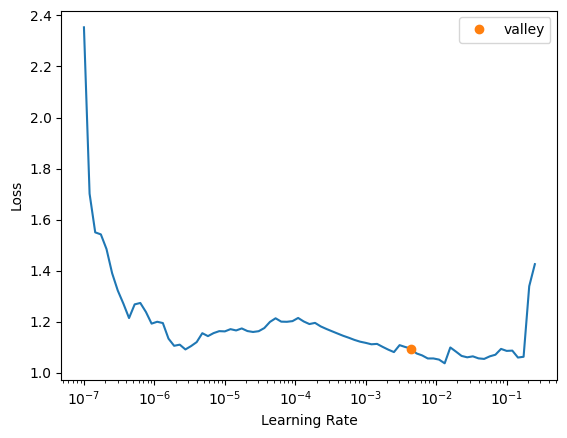

In [ ]:
learn_states.lr_find()

epoch,train_loss,valid_loss,time
0,0.439399,0.327266,03:55
1,0.343948,0.270754,03:19


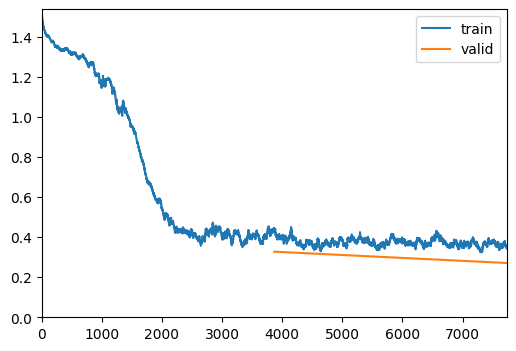

In [ ]:
learn_states.fit_one_cycle(2, lr_max=1e-4)#2e-4)

epoch,train_loss,valid_loss,time
0,0.883350,0.769530,00:11
1,0.777344,1.072872,00:11
2,0.688908,0.895392,00:11
3,0.687085,0.735030,00:11
4,0.716736,0.662901,00:11
5,0.720430,6.071524,00:11
6,0.658123,2.006618,00:11
7,0.746481,39.850430,00:11
8,0.979173,6.249897,00:11
9,0.679116,43.414227,00:11


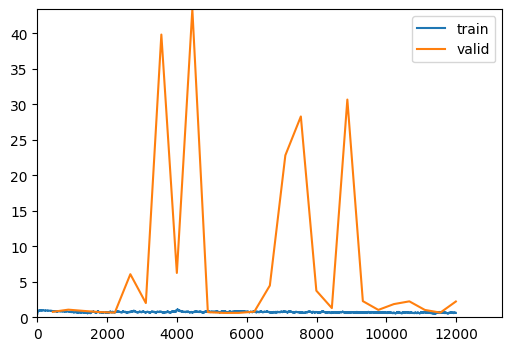

In [ ]:
learn_states.fit_one_cycle(30, lr_max=1e-5)

epoch,train_loss,valid_loss,time
0,0.767224,3.142674,00:11
1,0.794686,6.932698,00:12
2,0.645456,3.537908,00:11
3,0.767578,4.009755,00:11
4,0.749603,4.113332,00:11


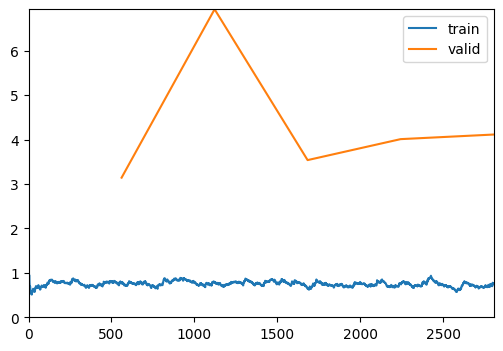

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-5)

In [ ]:
with torch.no_grad():
    x,y = learn_states.dls.valid.one_batch()
    pred = learn_states.model(x.cuda()).cpu()
    y = y.cpu()
    y, pred = y.squeeze(), pred.squeeze()

In [ ]:
y.shape, pred.shape

(torch.Size([58, 136]), torch.Size([58, 136, 4]))

In [ ]:
#pred

In [ ]:
#torch.argmax(pred,dim=-1)

  0%|          | 0/18 [00:00<?, ?it/s]

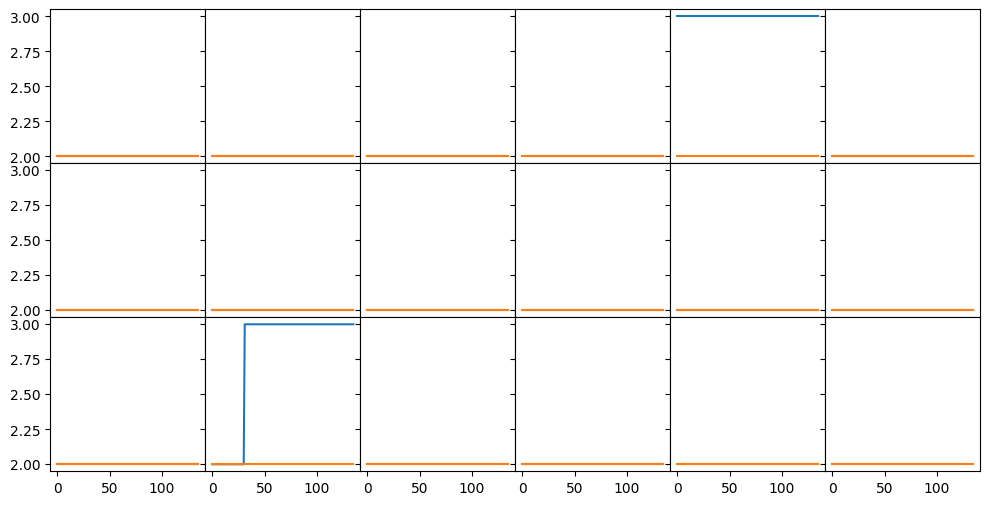

In [ ]:
n=3
fig, axs = plt.subplots(n,2*n, figsize=(12,6), 
                        sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0, hspace=0))
for i, ax in tenumerate(axs.flatten()):
    ax.plot(y[i]);ax.plot(torch.argmax(pred[i],dim=-1));

In [ ]:
MODEL_PATH = Path('../../../models')

In [ ]:
data_path, MODEL_PATH

(Path('/media/scratrch_data/nanoninjas/data/raw/medium_0/track_2'),
 Path('../../../models'))

In [ ]:
!ls ../../../models

logxresattn_bm_2d_1_to_4_cp_noisestd7to20nm.pth
logxresattn_bm_2d_1_to_4_cp.pth
logxresattn_bm_2d_1_to_5_cp_varlen_42.pth
logxresattn_bm_2d_72.pth
xresattn_bm_2d_paper.pth
xresattn_exp_2d_1_to_4_cp_locnoise7to20nm.pth
xresattn_exp_2d_1_to_4_cp.pth
xresattn_exp_2d_fbm_varlen.pth
xresattn_exp_2d_paper.pth
xresattn_states_2d_varlen.pth


In [ ]:
learn.path, learn.model_dir

(Path('.'), Path('/media/scratrch_data/gfernandez/STEProids/models'))

In [ ]:
learn_states.save('../../models/xresattn_states_2d_varlen')

Path('/media/scratrch_data/gfernandez/STEProids/models/../../models/xresattn_states_2d_varlen.pth')

# CPS

In [ ]:
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/baby/track_2/trajectories.npz")
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/medium_0/track_2/trajectories.npz")
bs_ = 200*20
dls = get_dls_array(data_path, bs_)
dim = 2

In [ ]:
preds_path = Path("/media/scratrch_data/nanoninjas/data/raw/baby/track_2/step_baby_pred.npz")
preds_path = Path("/media/scratrch_data/nanoninjas/data/raw/medium_0/track_2/step_medium_0_pred.npz")
bs_ = 200*20
dls = get_dls_array_preds(preds_path, data_path, bs_)
dim = 2

In [ ]:
np.savez_compressed("valid_idx",idx=np.array(dls.valid.idxs))

In [ ]:
dls.one_batch()

(tensor([[[ 1.2884, -1.5881],
          [ 1.0631, -1.5881],
          [ 1.0789, -1.6338],
          ...,
          [ 1.3081, -1.5831],
          [ 1.3154, -1.5675],
          [ 1.2619, -1.5533]],
 
         [[ 1.3359,  1.0078],
          [ 1.2890,  1.0078],
          [ 1.2884,  1.0037],
          ...,
          [ 1.2191,  0.9052],
          [ 1.2938,  0.9258],
          [ 1.3144,  0.9174]],
 
         [[ 1.3595,  1.1073],
          [ 1.3000,  1.1073],
          [ 1.2892,  1.2000],
          ...,
          [ 1.3105,  1.1554],
          [ 1.3243,  1.1919],
          [ 1.3441,  1.1909]],
 
         ...,
 
         [[ 1.7808, -1.5438],
          [ 1.7944, -1.5438],
          [ 1.7921, -1.5533],
          ...,
          [ 1.7016, -1.5403],
          [ 1.7090, -1.5574],
          [ 1.6817, -1.5589]],
 
         [[ 0.4691, -1.5685],
          [ 0.4292, -1.5685],
          [ 0.4416, -1.5627],
          ...,
          [ 0.6024, -1.5905],
          [ 0.6107, -1.6093],
          [ 0.5745, -1.5121

In [ ]:
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([7, 537, 2]), torch.Size([7, 537, 1]))

In [ ]:
assert not torch.all(y==0)

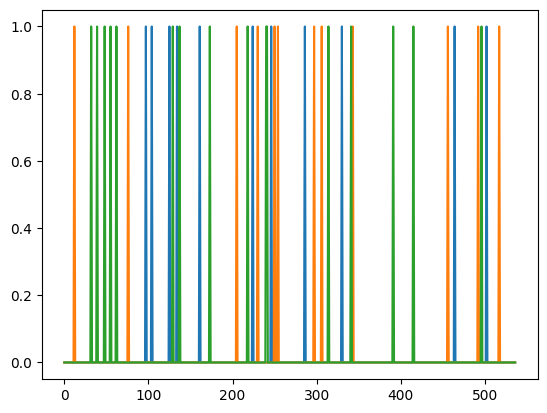

In [ ]:
plt.plot(y[torch.unique(torch.nonzero(y)[:,0])].cpu().squeeze().T.numpy());

In [ ]:
with default_device():
    model = XResAttn(dim, n_class=1, stem_szs=(32,), conv_blocks=[1, 1, 1],
                 block_szs=[128, 256, 512], dropout=0., pos_enc=False, n_encoder_layers=4,
                 dim_ff=512, nhead_enc=8, linear_layers=[],yrange=(0,1.05))

In [ ]:
model.act, model.activation

(fastai.layers.SigmoidRange(low=0, high=1.05),
 <function fastai.imports.noop(x=None, *args, **kwargs)>)

In [ ]:
XResAttn??

Init signature:
XResAttn(
    dim,
    n_class=5,
    conv_blocks=[1, 1],
    block=<class 'fastai.layers.ResBlock'>,
    block_szs=[64, 128],
    nhead_enc=1,
    n_encoder_layers=6,
    dim_ff=2048,
    dropout=0.1,
    pos_enc=True,
    linear_layers=[128],
    activation='relu',
    norm=True,
    yrange=(0, 2.05),
    *,
    expansion=1,
    p=0.0,
    c_in=1,
    n_out=1000,
    stem_szs=(32, 32, 64),
    widen=1.0,
    ndim=1,
    ks=3,
    stride=2,
    sa=False,
    stem_stride=False,
    act_cls=<class 'torch.nn.modules.activation.ReLU'>,
    groups=1,
    reduction=None,
    nh1=None,
    nh2=None,
    dw=False,
    g2=1,
    sym=False,
    norm_type=<NormType.Batch: 1>,
    pool=<function AvgPool at 0x73d59aeb3b00>,
    pool_first=True,
    padding=None,
    bias=None,
    bn_1st=True,
    transpose=False,
    init='auto',
    xtra=None,
    bias_std=0.01,
    dilation: Union[int, Tuple[int, int]] = 1,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
)
Sour

In [ ]:
class Noop(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x

In [ ]:
model.act = Noop()

In [ ]:
model

XResAttn(
  (norm): Normalization()
  (convs): XResBlocks(
    (0): ConvLayer(
      (0): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ResBlock(
        (convpath): Sequential(
          (0): ConvLayer(
            (0): Conv1d(32, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
            (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
          (1): ConvLayer(
            (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
            (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (idpath): Sequential(
          (0): ConvLayer(
            (0): Conv1d(32, 128, kernel_size=(1,), stride=(1,), bias=False)
            (1): BatchNorm1d(12

In [ ]:
with default_device():
    cps_label_weight=torch.tensor([423])
    loss_fn = BCEWithLogitsLossFlat(pos_weight=cps_label_weight)

In [ ]:
loss_ = []
x_ = torch.linspace(0,2,50)
for i in x_:
    mode_guess = torch.tensor([[[i]]*x.shape[1]]*x.shape[0], device=default_device())
    mode_guess[:,-1] = 1.
    mode_guess.shape, y.shape
    mode_guess_loss = loss_fn_state(mode_guess.cuda(), y.cuda())
    loss_.append(mode_guess_loss.item())

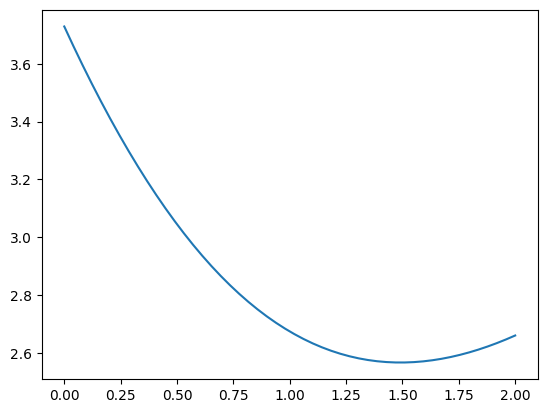

In [ ]:
plt.plot(x_.cpu(), loss_); # medium_0

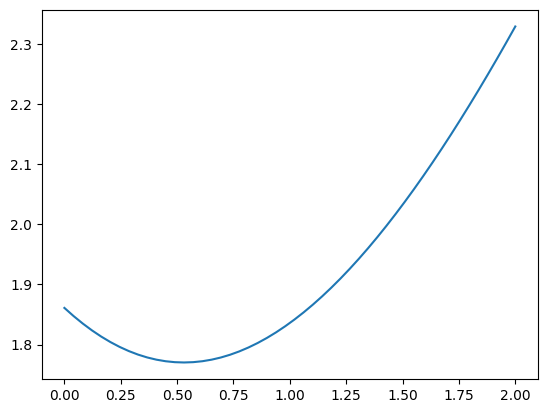

In [ ]:
plt.plot(x_.cpu(), loss_); # baby

In [ ]:
cbs = ShowGraphCallback()

In [ ]:
MODEL_PATH

Path('/media/scratrch_data/gfernandez/STEProids/models')

In [ ]:
learn_cps = Learner(dls, model, loss_func=loss_fn,
                model_dir=MODEL_PATH, cbs=cbs)
learn_cps.to(default_device());

In [ ]:
learn_cps.dls.one_batch()[0].shape

torch.Size([15, 252, 2])

A rather handy functionality of the learner is the `lr_find` method. This function trains the model for a few mini-batches changing the learning rate. Then, we can visualize the loss and determine the regions where the model is learning, where the learning rate is too low and where it diverges.

In [ ]:
learn_cps.summary()

XResAttn (Input shape: 1 x 398 x 2)
Layer (type)         Output Shape         Param #    Trainable 
                     1 x 398 x 2         
Normalization                                                  
____________________________________________________________________________
                     1 x 32 x 398        
Conv1d                                    192        True      
BatchNorm1d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     1 x 128 x 398       
Conv1d                                    12288      True      
BatchNorm1d                               256        True      
ReLU                                                           
Conv1d                                    49152      True      
BatchNorm1d                               256        True      
Conv1d                                    40

SuggestedLRs(valley=0.009120108559727669)

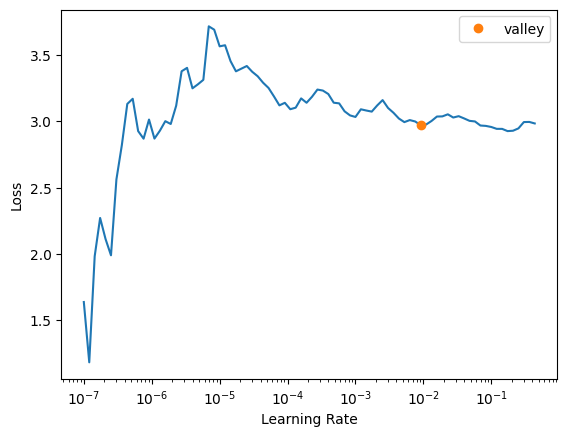

In [ ]:
learn_cps.lr_find()

epoch,train_loss,valid_loss,time
0,1.997588,2.577401,00:23
1,1.673083,2.102674,00:12


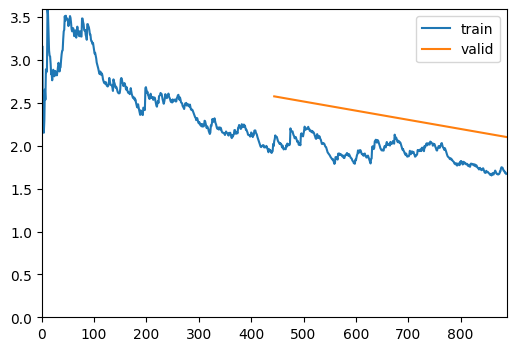

In [ ]:
learn_cps.fit_one_cycle(2, lr_max=1e-4)

epoch,train_loss,valid_loss,time
0,1.457224,nan,09:31
1,1.408830,nan,08:59
2,1.324513,nan,09:12
3,1.257914,nan,08:57


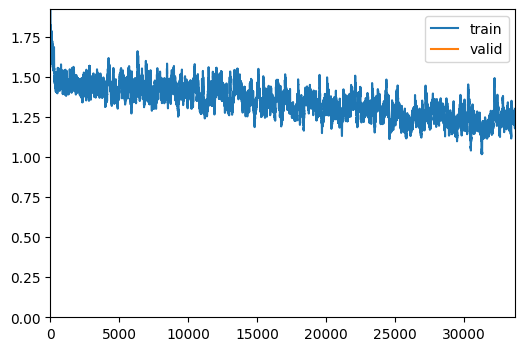

In [ ]:
learn_cps.fit_one_cycle(4, lr_max=1e-4)

epoch,train_loss,valid_loss,time
0,1.225955,nan,09:22
1,1.186478,nan,09:15
2,1.307331,nan,08:31
3,1.271312,nan,08:29
4,1.154478,nan,08:52
5,1.137915,nan,08:42
6,1.249946,nan,08:42
7,1.207906,nan,08:17


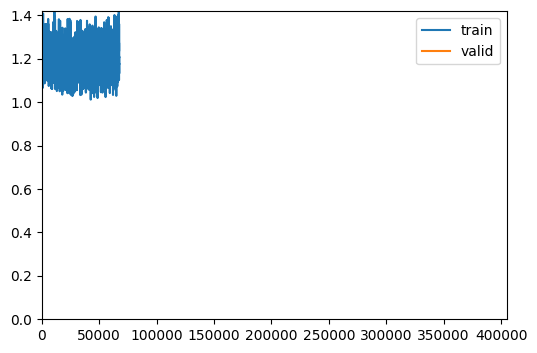

In [ ]:
learn_cps.fit_one_cycle(6*8, lr_max=1e-4)

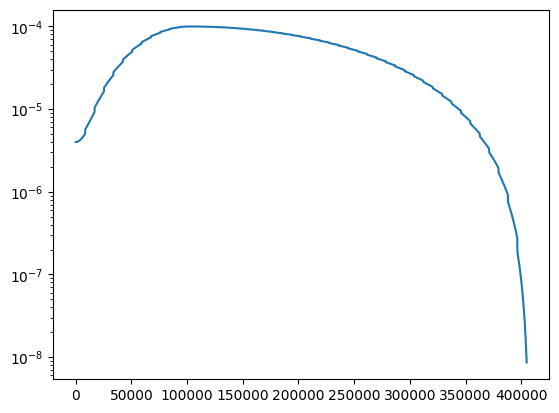

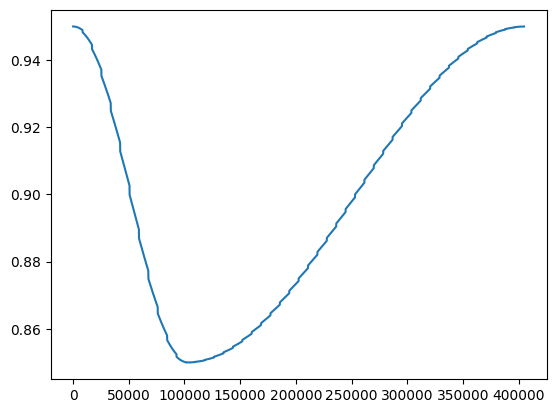

In [ ]:
plt.plot(learn.recorder.hps['lr']); plt.yscale('log')
plt.figure();plt.plot(learn.recorder.hps['mom']);

epoch,train_loss,valid_loss,time
0,0.828910,1.063623,09:29


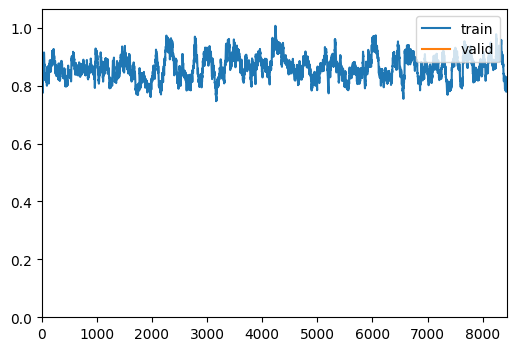

In [ ]:
learn.fit_one_cycle(1, lr_max=1e-5)#2e-4)

In [ ]:
with torch.no_grad():
    x,y = learn_cps.dls.valid.one_batch()
    pred = learn_cps.model(x.cuda()).cpu()
    y = y.cpu()
    y, pred = y.squeeze(), pred.squeeze()

In [ ]:
y.shape, pred.shape

(torch.Size([34, 117]), torch.Size([34, 117]))

In [ ]:
torch.all(y==0)

tensor(False)

In [ ]:
torch.sigmoid(pred)#>0.95

tensor([[1.2507e-04, 3.8667e-04, 1.7686e-04,  ..., 4.9046e-04, 4.3360e-04,
         7.3137e-04],
        [5.6637e-04, 2.3839e-04, 2.3711e-04,  ..., 1.2856e-03, 7.4216e-04,
         1.0819e-03],
        [2.6768e-05, 3.7368e-04, 1.6506e-04,  ..., 9.7488e-05, 3.2040e-06,
         1.0098e-05],
        ...,
        [3.0931e-04, 2.8130e-04, 2.9154e-04,  ..., 1.7212e-03, 1.4751e-03,
         3.7569e-04],
        [5.5794e-05, 1.9917e-04, 2.4316e-04,  ..., 2.7467e-04, 7.5955e-04,
         6.9792e-04],
        [1.5677e-04, 1.4166e-04, 5.4627e-03,  ..., 3.4394e-03, 4.7564e-04,
         3.1551e-04]])

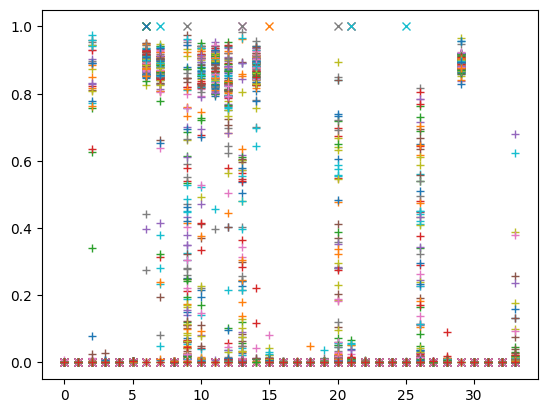

In [ ]:
plt.plot(y.numpy(),'x');
plt.plot((torch.sigmoid(pred)).numpy(),'+');

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
8
[ 6  7  9 13 15 20 21 25  8  9 10 11 12 13 14 15 16 17]


  0%|          | 0/18 [00:00<?, ?it/s]

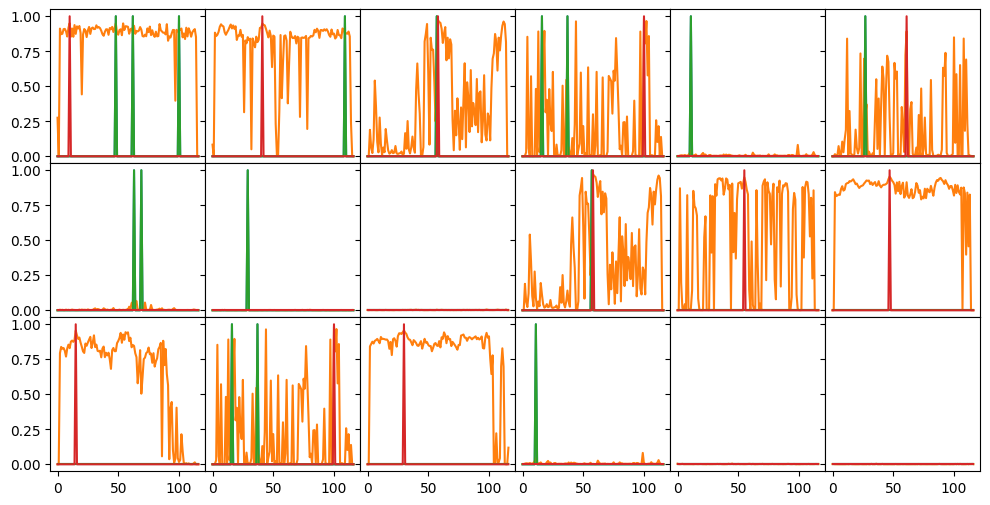

In [ ]:
n=3
fig, axs = plt.subplots(n,2*n, figsize=(12,6), 
                        sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0, hspace=0))
y_idx = np.arange(len(axs.flatten()))
print(y_idx)
y_u = torch.unique(torch.nonzero(y)[:,0])
print(len(y_u))
y_idx[:len(y_u)] = y_u
print(y_idx)
for i, ax in tenumerate(axs.flatten()):
    pr = torch.sigmoid(pred[y_idx[i]])
    # ax.plot(y[y_idx[i]]);ax.plot(pr.diff());
    ax.plot(y[y_idx[i]]);ax.plot(pr);
    m = (pr==pr.max()) if torch.any(pr>0.5) else np.zeros_like(pr)
    ax.plot(y[y_idx[i]]);ax.plot(m);

In [ ]:
learn.act

Noop()

In [ ]:
out = learn.get_preds(dl=learn.dls.valid, reorder=False, act=Noop())

In [ ]:
out = learn.get_preds(dl=learn.dls.train, reorder=False, act=Noop(), with_loss=True)

In [ ]:
out[-1].mean()

TensorBase(1.0057)

In [ ]:
pred_logit, targ = out

In [ ]:
l = []
with torch.no_grad():
    for i in range(len(pred_logit)):
        l.append(loss_fn(pred_logit[i].cuda(), targ[i].cuda()).item())

In [ ]:
sum(np.isnan(l))

1

In [ ]:
np.nanmean(l)

3.145498723373258

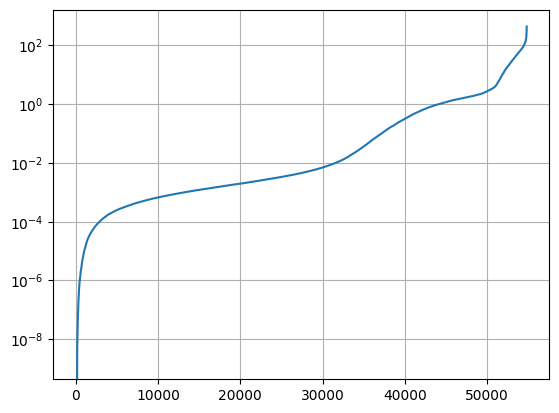

In [ ]:
plt.plot(np.sort(l)); plt.yscale('log'); plt.grid()

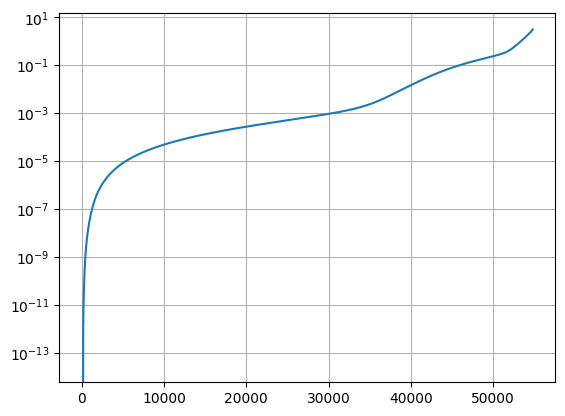

In [ ]:
plt.plot(np.cumsum(np.sort(l))/len(l)); plt.yscale('log'); plt.grid()

In [ ]:
pred_prob = L(torch.sigmoid(p).squeeze() for p in pred_logit)

In [ ]:
i=0

41


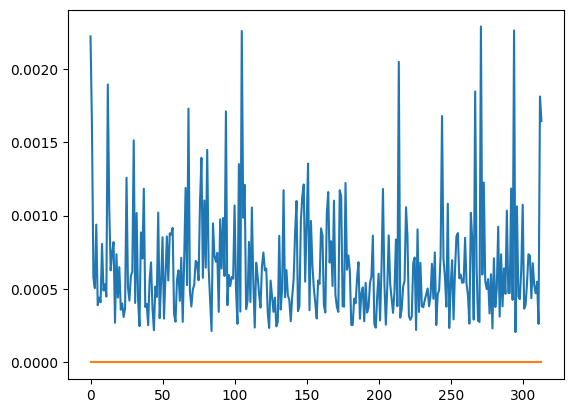

In [ ]:
i+=1
print(i)
plt.plot(pred_prob[i]);plt.plot(targ[i]);# plt.ylim(0.85,.95);

### with len

In [ ]:
from andi_datasets.utils_challenge import single_changepoint_error, ensemble_changepoint_error

In [ ]:
pred_ = L(p>0.9 for p in pred_prob)

In [ ]:
pred_cps = L(torch.argwhere(p).squeeze(-1).numpy() for p in pred_)
true_cps = L(torch.argwhere(t.squeeze()).squeeze(-1).numpy() for t in targ)

In [ ]:
TP_rmse, JI = zip(*[single_changepoint_error(true_cps_, pred_cps_,)
               for true_cps_, pred_cps_ in zip(true_cps, pred_cps)])

In [ ]:
TP_rmse_e, JI_e = ensemble_changepoint_error(true_cps, pred_cps,)

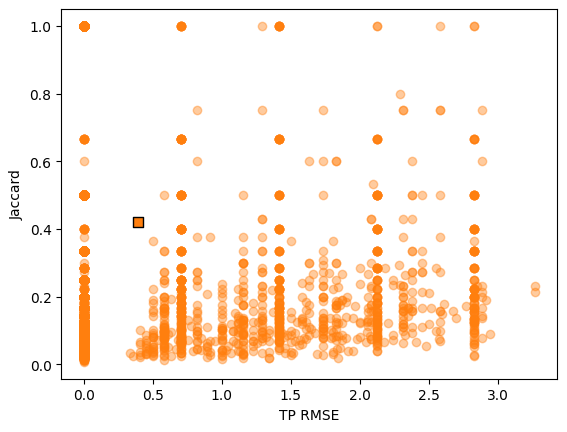

In [ ]:
plt.scatter(TP_rmse, JI, c = 'C1', alpha = 0.4)
plt.scatter(TP_rmse_e, JI_e , c = 'C1', s = 50, marker = 's', edgecolors = 'k')
plt.setp(plt.gca(), xlabel = 'TP RMSE', ylabel = 'Jaccard');

In [ ]:
TP_rmse_e, JI_e

(0.39240983313870853, 0.4205726345803079)

In [ ]:
def JITP_thresh(pred_prob, p_threshold, true_cps):
    pred_ = L(p>p_threshold for p in pred_prob)
    pred_cps = L(torch.argwhere(p).squeeze(-1).numpy() for p in pred_)
    return ensemble_changepoint_error(true_cps, pred_cps,)

In [ ]:
TP_, JI_ = [],[]
p_ = np.linspace(.90,.99,7)
for p_threshold in p_:
    TP_rmse_e, JI_e = JITP_thresh(pred_prob, p_threshold, true_cps)
    TP_.append(TP_rmse_e), JI_.append(JI_e)

In [ ]:
len(np.array([]))

0

In [ ]:
true_cps[1][:-1], pred_cps[-40]

(array([102, 244]), array([121]))

In [ ]:
ensemble_changepoint_error(true_cps[0][:-1], true_cps[1][:-1],)

(0, 1)

In [ ]:
true_len = L(cps[-1:] for cps in true_cps)

In [ ]:
# metrics when predicting only the length of the trajectories
TP_rmse_len, JI_len = ensemble_changepoint_error(true_cps, true_len)
TP_rmse_len, JI_len

(0.0, 0.6782191162138391)

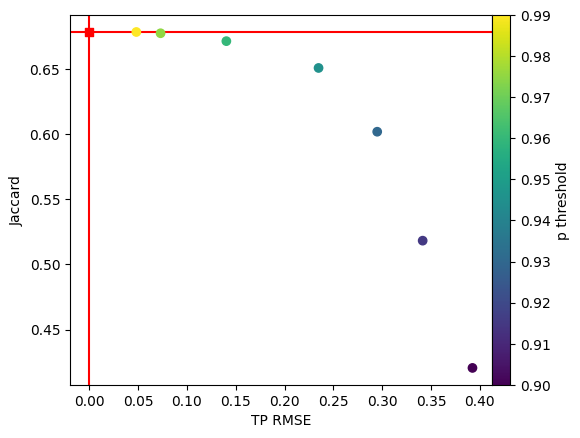

In [ ]:
plt.scatter(TP_rmse_len, JI_len, marker='s',c='r', );
plt.axvline(TP_rmse_len, c='r', zorder=-1); plt.axhline(JI_len, c='r', zorder=-1);
plt.scatter(TP_, JI_, c=p_);
plt.colorbar(pad=0, label='p threshold');
plt.setp(plt.gca(), xlabel = 'TP RMSE', ylabel = 'Jaccard');

### with no len

In [ ]:
from andi_datasets.utils_challenge import changepoint_assignment

In [ ]:
def single_changepoint_error_nolen(GT, preds, threshold = 5):
    '''
    Given the groundtruth and predicted changepoints for a single trajectory,
    first handles the empty cases, i.e., when there a no change points,
    then, solves the assignment problem between changepoints,
    and returns the RMSE of the true positive pairs and the Jaccard index.
    
    Parameters
    ----------
    GT : list
        List of groundtruth change points.
    preds : list
        List of predicted change points.
    threshold : float
        Distance from which predictions are considered to have failed.
        They are then assigned this number in the RMSE.
    
    Returns
    -------
    tuple
        - TP_rmse: root mean square error of the true positive change points.
        - Jaccard Index of the ensemble predictions        
        
    '''
    if len(GT)==0:  # when there is no true_cp:
        if len(preds)==0:    return 0,1  # perfect
        else:
            FP = len(preds)
            return min(FP,threshold), 0
    elif len(preds)==0:  # when there is one or more true_cp but preds is empty
        FN = len(GT)
        return min(FN,threshold), 0
    else: # there are one or more preds and true cps:
        assignment, _ = changepoint_assignment(GT, preds) # only if true_cp and pred_cp are non empty
        assignment = np.array(assignment)
        
        TP, FP, FN = 0, 0, 0
        TP_rmse = []
        for p in assignment.transpose():
            if np.abs(GT[p[0]] - preds[p[1]]) < threshold:
                TP += 1
                TP_rmse.append((GT[p[0]] - preds[p[1]])**2)
            else: # if the cp candidate is not in threshold
                # cp_candidate is a False Positive
                FP += 1
                # and the prediction missed a cp, hence, there is a False Negative
                FN += 1

        # Checking false positive and missed events
        if len(preds) > len(GT):
            FP += len(preds) - len(GT)
        elif len(preds) < len(GT):
            FN += len(GT) - len(preds)

        # Calculating RMSE
        TP_rmse = np.sqrt(np.mean(TP_rmse)) if len(TP_rmse) > 0 else threshold
        
        return TP_rmse, jaccard_index(TP, FP, FN)

In [ ]:
def ensemble_changepoint_error_nolen(GT_ensemble, pred_ensemble, threshold = 5):    
    ''' 
    Given an ensemble of groundtruth and predicted change points,
    iterates over each trajectory's changepoints.
    For each trajectory ground truth (GT) and prediction pair,
    it handles the empty cases, and if they are not empty,
    it solves the assignment problem between changepoints. 
    Then, calculates the RMSE of the true positive (TP) pairs and
    the Jaccard index over the ensemble of changepoints 
    (i.e., not the mean of the TP pairs w.r.t. to the trajectories)
    
    Parameters
    ----------
    GT_ensemble : list, array
        Ensemble of groutruth change points.
    pred_ensemble : list
        Ensemble of predicted change points.
    threshold : float
        Distance from which predictions are considered to have failed. They are then assigned this number.
    
    Returns
    -------
    tuple
        - TP_rmse: root mean square error of the true positive change points.
        - Jaccard Index of the ensemble predictions
    
    '''
    
    TP, FP, FN = 0, 0, 0
    TP_rmse = []
    num_cp_GT = 0
    for true_cp, pred_traj in zip(GT_ensemble, pred_ensemble):
        num_cp_GT += len(true_cp)
        #-------------------------------------------------------------
        if len(true_cp)==0:  # when there is no true_cp:
            if len(pred_traj)==0:    TP_rmse.append(0)  # perfect
            else:
                FP += len(pred_traj)
                TP_rmse.append(min(FP,threshold)**2)
        elif len(pred_traj)==0:  # when there is one or more true_cp but preds is empty
            FN += len(true_cp)
            TP_rmse.append(min(FN,threshold)**2)
        else: # there are one or more preds and true cps:
            assignment, _ = changepoint_assignment(true_cp, pred_traj) # only if true_cp and pred_cp are non empty
            assignment = np.array(assignment)
            for p in assignment.transpose():
                if np.abs(true_cp[p[0]] - pred_traj[p[1]]) < threshold:
                    TP += 1
                    TP_rmse.append((true_cp[p[0]] - pred_traj[p[1]])**2)
                else: # if the cp candidate is not in threshold
                    # cp_candidate is a False Positive
                    FP += 1
                    # and the prediction missed a cp, hence, there is a False Negative
                    FN += 1
    
            # Checking false positive and missed events
            if len(pred_traj) > len(true_cp):
                FP += len(pred_traj) - len(true_cp)
            elif len(pred_traj) < len(true_cp):
                FN += len(true_cp) - len(pred_traj)
        #-------------------------------------------------------------
        # assignment, _ = changepoint_assignment(gt_traj, pred_traj)
        # assignment = np.array(assignment)
        
        # for p in assignment.transpose():
            
        #     if np.abs(gt_traj[p[0]] - pred_traj[p[1]]) < threshold:
        #         TP += 1
        #         TP_rmse.append((gt_traj[p[0]] - pred_traj[p[1]])**2)
        #     else:
        #         FP += 1
        #         FN += 1    
                
        # # Checking false positive and missed events
        # if len(pred_traj) > len(gt_traj):
        #     FP += len(pred_traj) - len(gt_traj)
        # elif len(pred_traj) < len(gt_traj):
        #     FN += len(gt_traj) - len(pred_traj)
        #--------------------------------------------------------------
    # after the ensemble loop
    if TP+FP+FN == 0:
        if num_cp_GT == 0:    return 0, 1  # this means there where no CP both in GT and Pred
        warnings.warn('No segments found in your predictions dataset.')
        return threshold, 0
        
    # Calculating RMSE for all TP
    TP_rmse = np.sqrt(np.mean(TP_rmse)) if len(TP_rmse) > 0 else threshold
        
    return TP_rmse, jaccard_index(TP, FP, FN)

In [ ]:
torch.max(pred_prob[0], dim=0, keepdim=True).indices#.numpy()

tensor([83])

In [ ]:
pred_cps = L(torch.max(p, dim=0, keepdim=True).indices.numpy() if torch.any(p>0.85) else np.array([],dtype=int) for p in pred_prob)

In [ ]:
pred_cps

(#54812) [array([83]),array([], dtype=int64),array([23]),array([125]),array([], dtype=int64),array([], dtype=int64),array([], dtype=int64),array([], dtype=int64),array([], dtype=int64),array([], dtype=int64)...]

In [ ]:
true_cps = L(torch.argwhere(t.squeeze()).squeeze(-1).numpy() for t in targ)

In [ ]:
true_cps

(#54812) [array([37, 86]),array([], dtype=int64),array([22]),array([], dtype=int64),array([], dtype=int64),array([], dtype=int64),array([], dtype=int64),array([], dtype=int64),array([], dtype=int64),array([], dtype=int64)...]

In [ ]:
TP_rmse, JI = zip(*[single_changepoint_error_nolen(true_cps_, pred_cps_,)
               for true_cps_, pred_cps_ in zip(true_cps, pred_cps)])

In [ ]:
TP_rmse_e, JI_e = ensemble_changepoint_error_nolen(true_cps, pred_cps,)

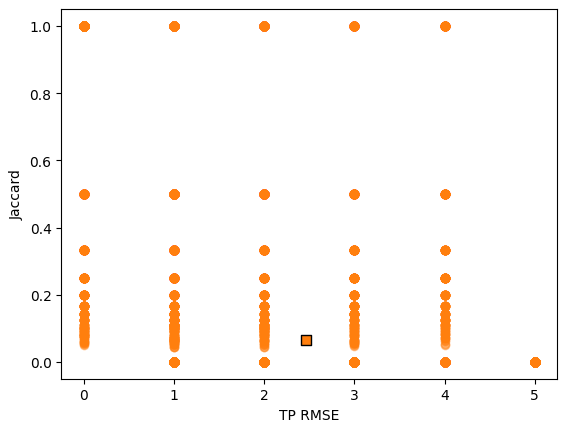

In [ ]:
plt.scatter(TP_rmse, JI, c = 'C1', alpha = 0.4)
plt.scatter(TP_rmse_e, JI_e , c = 'C1', s = 50, marker = 's', edgecolors = 'k')
plt.setp(plt.gca(), xlabel = 'TP RMSE', ylabel = 'Jaccard');

In [ ]:
TP_rmse_e, JI_e

(0.39240983313870853, 0.4205726345803079)

In [ ]:
def JITP_thresh(pred_prob, p_threshold, true_cps):
    pred_ = L(p>p_threshold for p in pred_prob)
    pred_cps = L(torch.argwhere(p).squeeze(-1).numpy() for p in pred_)
    return ensemble_changepoint_error(true_cps, pred_cps,)

In [ ]:
TP_, JI_ = [],[]
p_ = np.linspace(.90,.99,7)
for p_threshold in p_:
    TP_rmse_e, JI_e = JITP_thresh(pred_prob, p_threshold, true_cps)
    TP_.append(TP_rmse_e), JI_.append(JI_e)

In [ ]:
len(np.array([]))

0

In [ ]:
true_cps[1][:-1], pred_cps[-40]

(array([102, 244]), array([121]))

In [ ]:
ensemble_changepoint_error(true_cps[0][:-1], true_cps[1][:-1],)

(0, 1)

In [ ]:
true_len = L(cps[-1:] for cps in true_cps)

In [ ]:
# metrics when predicting only the length of the trajectories
TP_rmse_len, JI_len = ensemble_changepoint_error(true_cps, true_len)
TP_rmse_len, JI_len

(0.0, 0.6782191162138391)

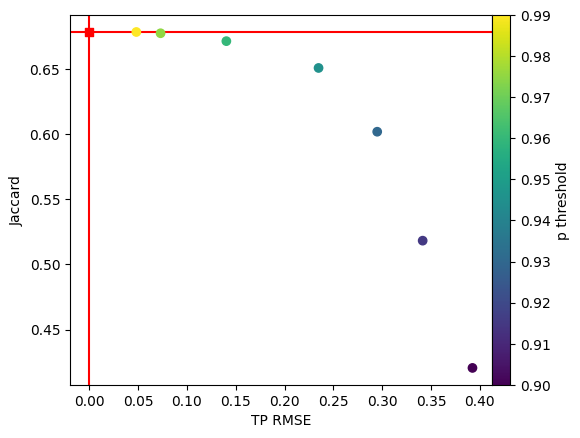

In [ ]:
plt.scatter(TP_rmse_len, JI_len, marker='s',c='r', );
plt.axvline(TP_rmse_len, c='r', zorder=-1); plt.axhline(JI_len, c='r', zorder=-1);
plt.scatter(TP_, JI_, c=p_);
plt.colorbar(pad=0, label='p threshold');
plt.setp(plt.gca(), xlabel = 'TP RMSE', ylabel = 'Jaccard');

### save model

In [ ]:
MODEL_PATH = Path('../../../models')

In [ ]:
data_path, MODEL_PATH

(Path('/media/scratrch_data/nanoninjas/data/raw/medium_0/track_2'),
 Path('../../../models'))

In [ ]:
!ls ../../../models

logxresattn_bm_2d_1_to_4_cp_noisestd7to20nm.pth
logxresattn_bm_2d_1_to_4_cp.pth
logxresattn_bm_2d_1_to_5_cp_varlen_42.pth
logxresattn_bm_2d_72.pth
xresattn_bm_2d_paper.pth
xresattn_exp_2d_1_to_4_cp_locnoise7to20nm.pth
xresattn_exp_2d_1_to_4_cp.pth
xresattn_exp_2d_fbm_varlen.pth
xresattn_exp_2d_paper.pth
xresattn_states_2d_varlen.pth


In [ ]:
learn_cps.path, learn_cps.model_dir

(Path('.'), Path('/media/scratrch_data/gfernandez/STEProids/models'))

In [ ]:
# learn.save('../../models/xresattn_cps_2d_varlen_xy') # from xy input not alpha, D, State predictions
learn_cps.save('../../models/xresattn_cps_2d_varlen_predalphalog10D') # from alpha, D, predictions

Path('/media/scratrch_data/gfernandez/STEProids/models/../../models/xresattn_cps_2d_varlen_predalphalog10D.pth')

### profile

In [ ]:
%load_ext line_profiler

In [ ]:
pred_cps = L(torch.argwhere(p).squeeze(-1).numpy() for p in pred_)

In [ ]:
pred_cps = L(np.argwhere(p.numpy()).squeeze(-1) for p in pred_)

In [ ]:
pred_cps[-20:]

(#20) [array([282]),array([282]),array([397]),array([397]),array([397]),array([397]),array([397]),array([397]),array([397]),array([397])...]

In [ ]:
%lprun -u 1 -f JITP_thresh JITP_thresh(pred_prob, p_threshold, true_cps)

Timer unit: 1 s

Total time: 4.9039 s
File: /tmp/ipykernel_1453314/2737668943.py
Function: JITP_thresh at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def JITP_thresh(pred_prob, p_threshold, true_cps):
     2         1          1.0      1.0     20.1      pred_ = L(p>p_threshold for p in pred_prob)
     3         1          2.3      2.3     47.3      pred_cps = L(torch.argwhere(p).squeeze(-1).numpy() for p in pred_)
     4         1          1.6      1.6     32.7      return ensemble_changepoint_error(true_cps, pred_cps,)